# Overview

https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

## Description

Example baseline submissions are available as part of the pylearn2 python package available at https://github.com/lisa-lab/pylearn2

The baseline submissions for this contest are in pylearn2/scripts/icml_2013_wrepl/emotions


## Evaluation

Submissions are scored based on their accuracy of predicting which of the seven classes should be assigned to each image

# Data

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. __The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).__

train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.

The training set consists of 28,709 examples. The public test set used for the leaderboard consists of 3,589 examples. The final test set, which was used to determine the winner of the competition, consists of another 3,589 examples.

This dataset was prepared by Pierre-Luc Carrier and Aaron Courville, as part of an ongoing research project. They have graciously provided the workshop organizers with a preliminary version of their dataset to use for this contest.

# Import Libs

In [13]:
import numpy as np
import pandas as pd
import os, sys, warnings, importlib, sklearn, scipy
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.size']=14
mpl.rcParams['figure.facecolor']='white'

# Inspect the Data

In [20]:
df = pd.read_csv('Data/fer2013/fer2013.csv')

In [21]:
emotion_dict = {0:'Angry',
                1:'Disgust', 
                2:'Fear',
                3:'Happy',
                4:'Sad', 
                5:'Surprise',
                6:'Neutral'}

In [22]:
for c in df:
    print(c,df[c].unique())

emotion [0 2 4 6 3 5 1]
pixels ['70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 

# Visualize the Data


 Angry (subset of 100 imgs)------------------


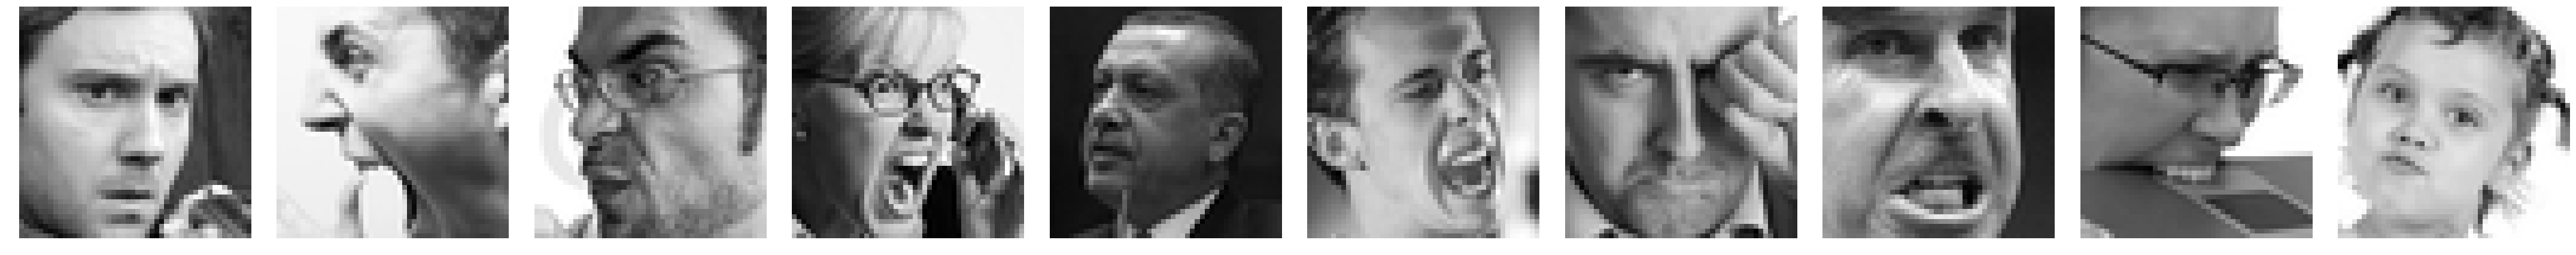

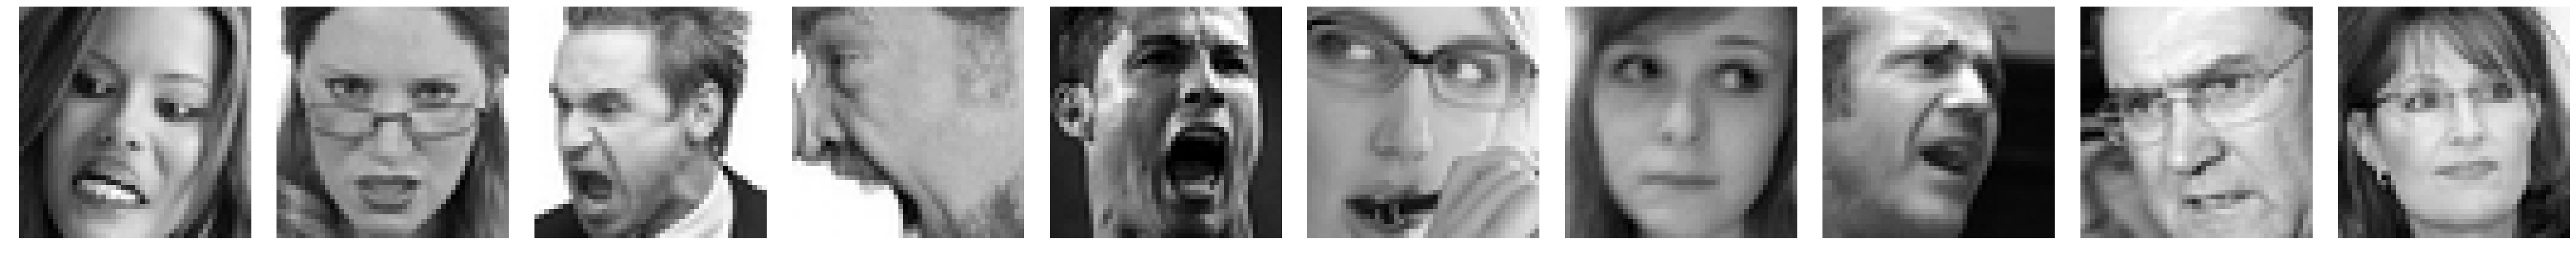

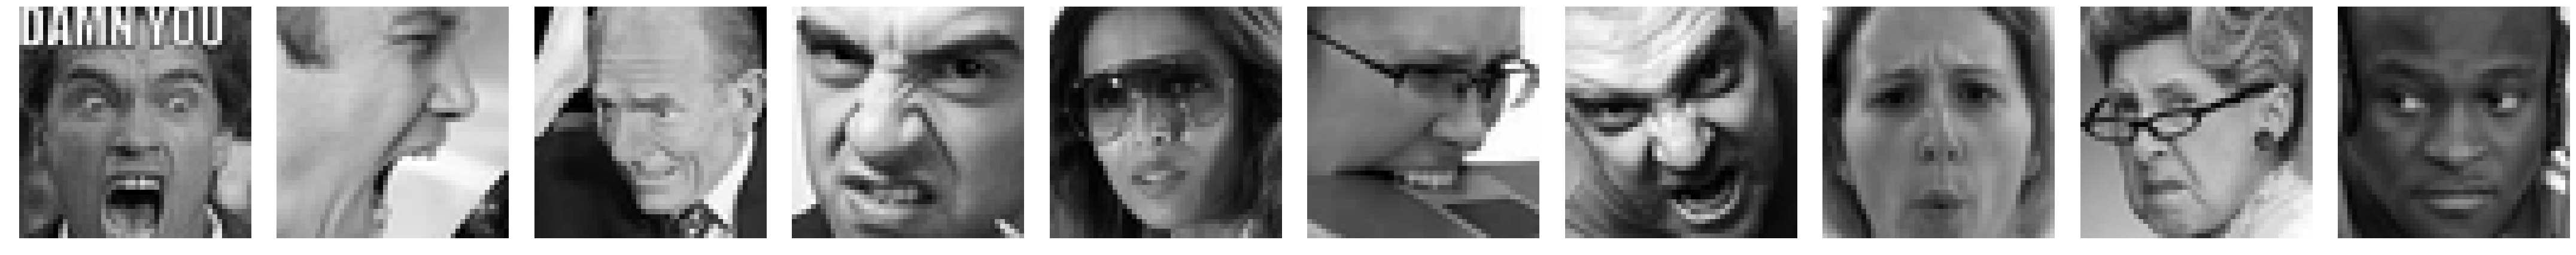

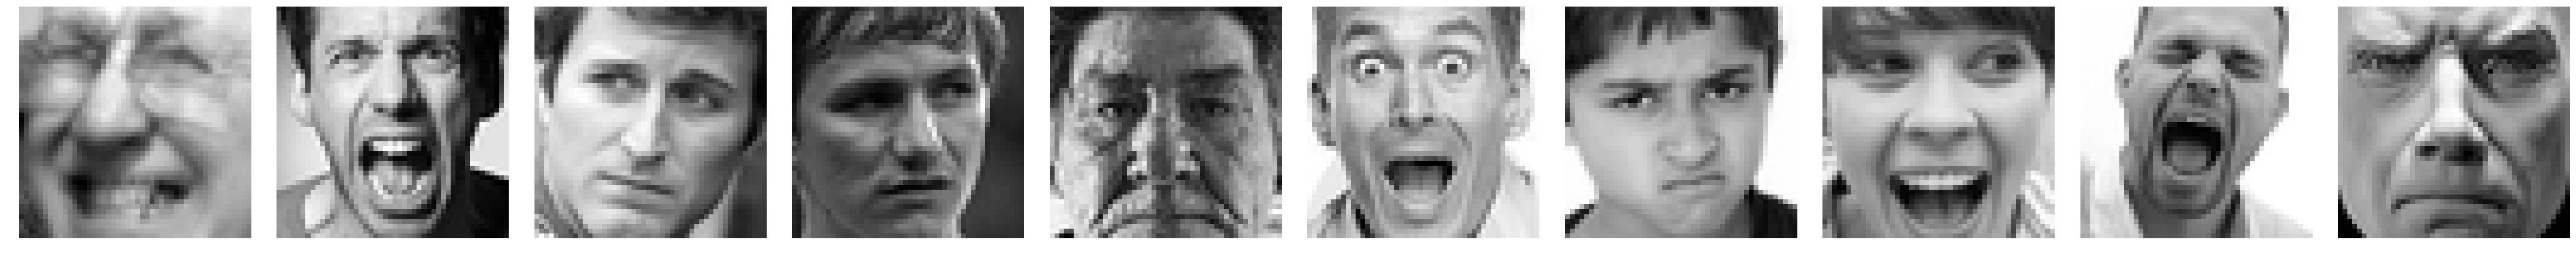

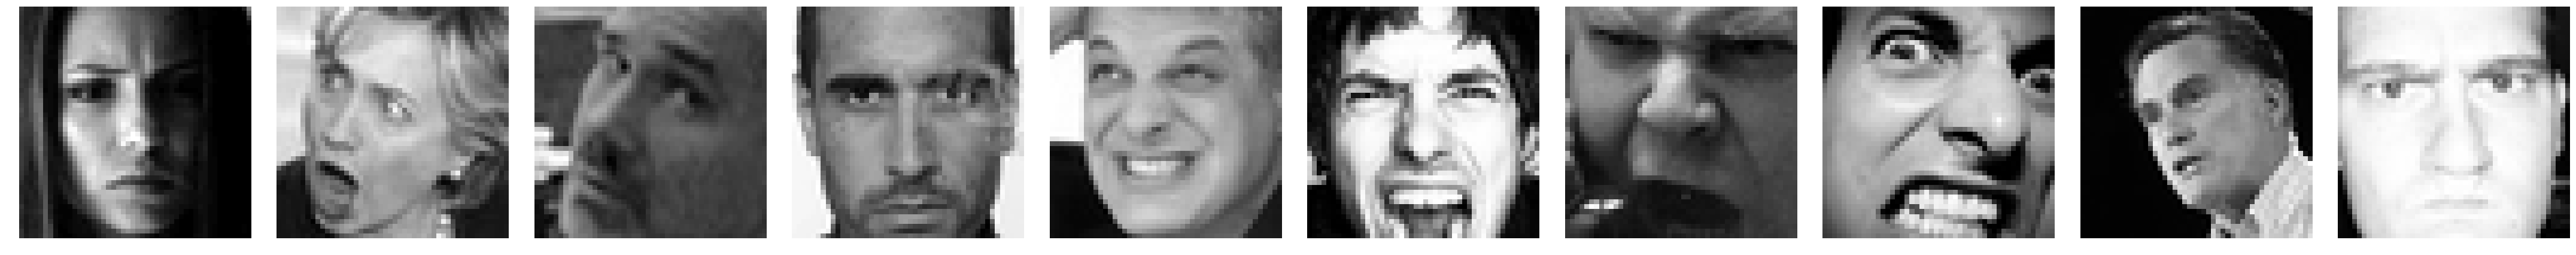

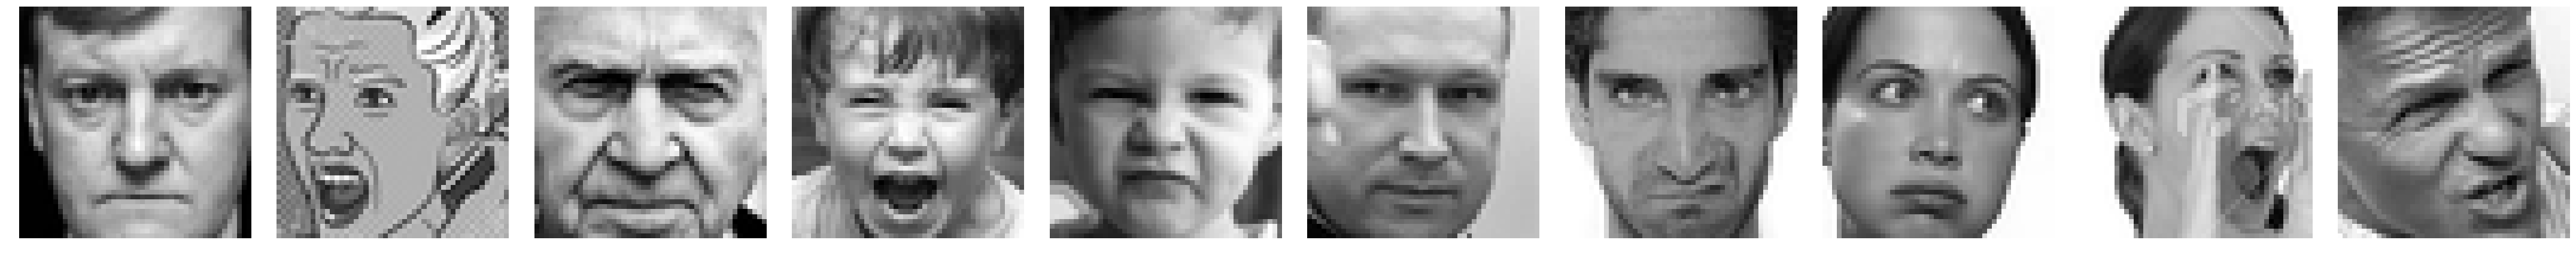

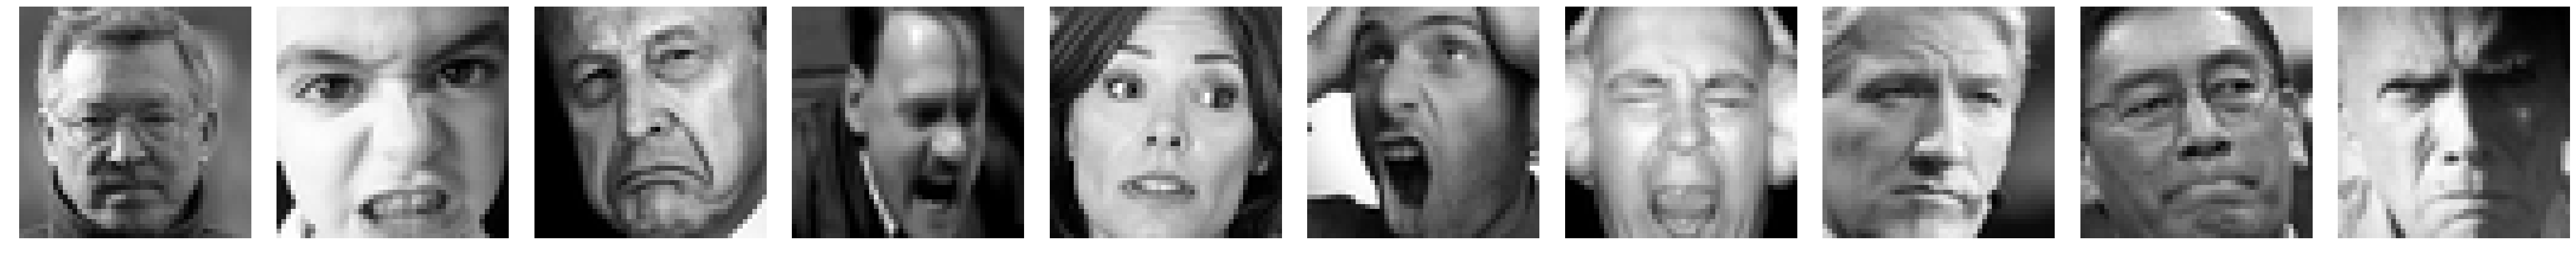

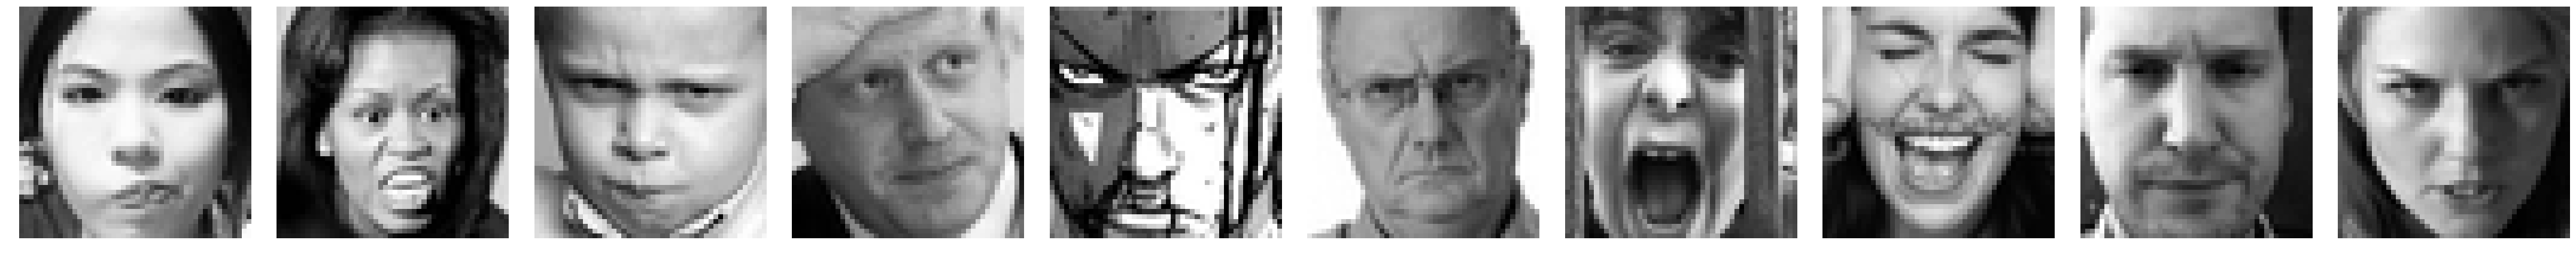

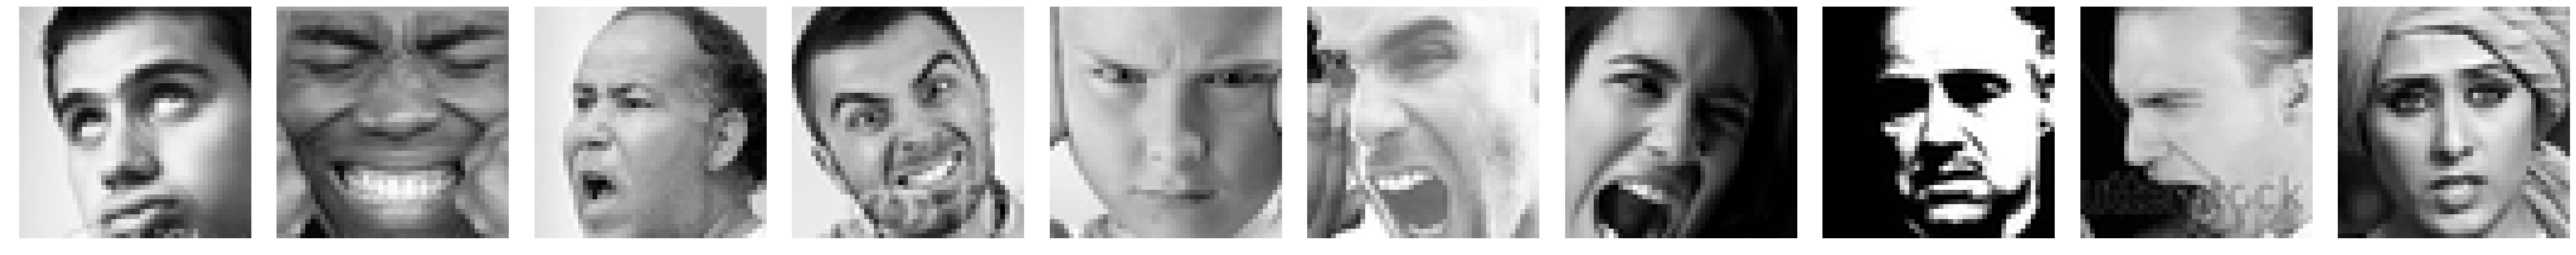

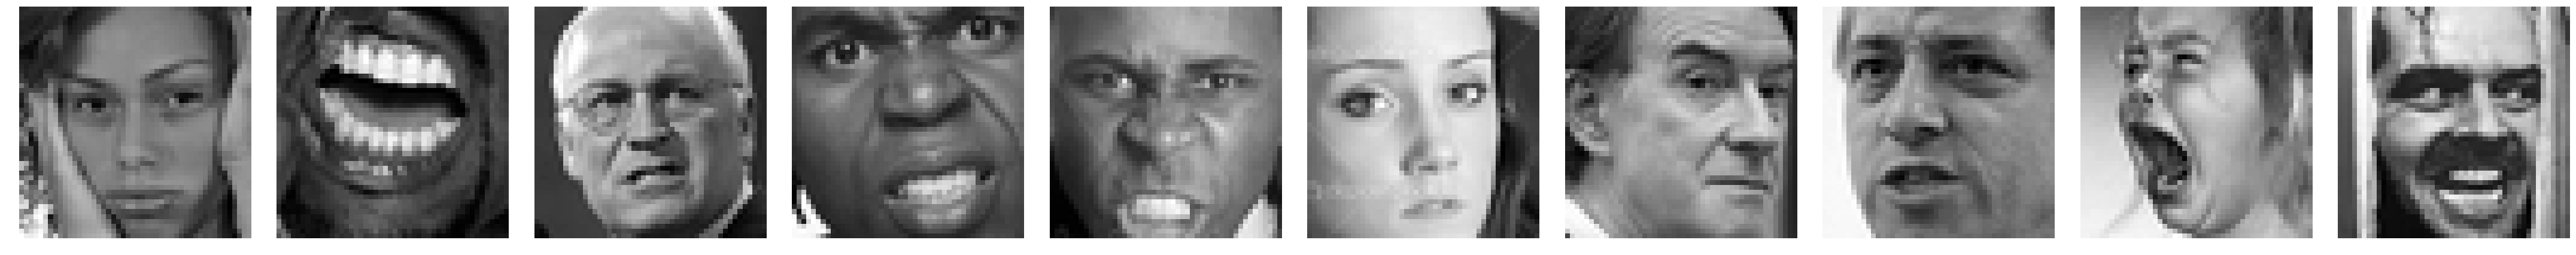


 Disgust (subset of 100 imgs)------------------


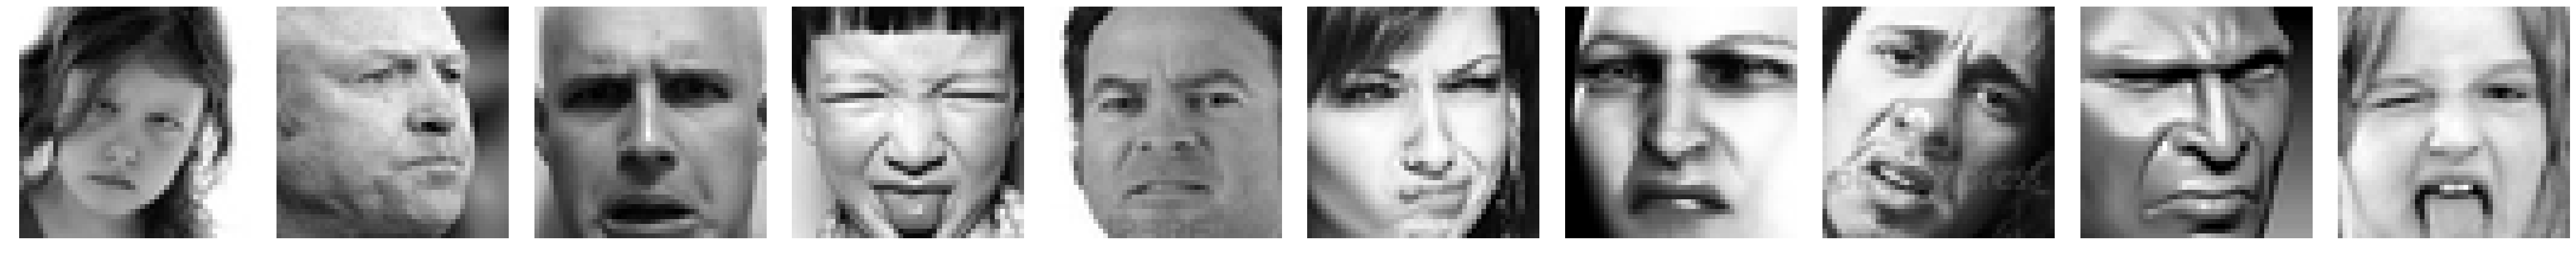

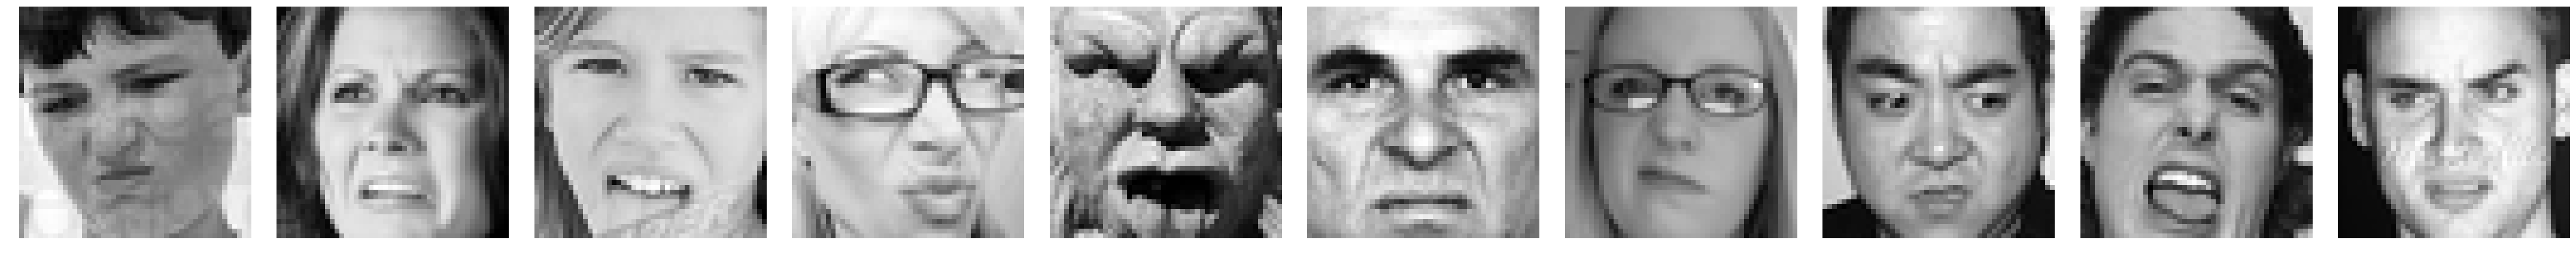

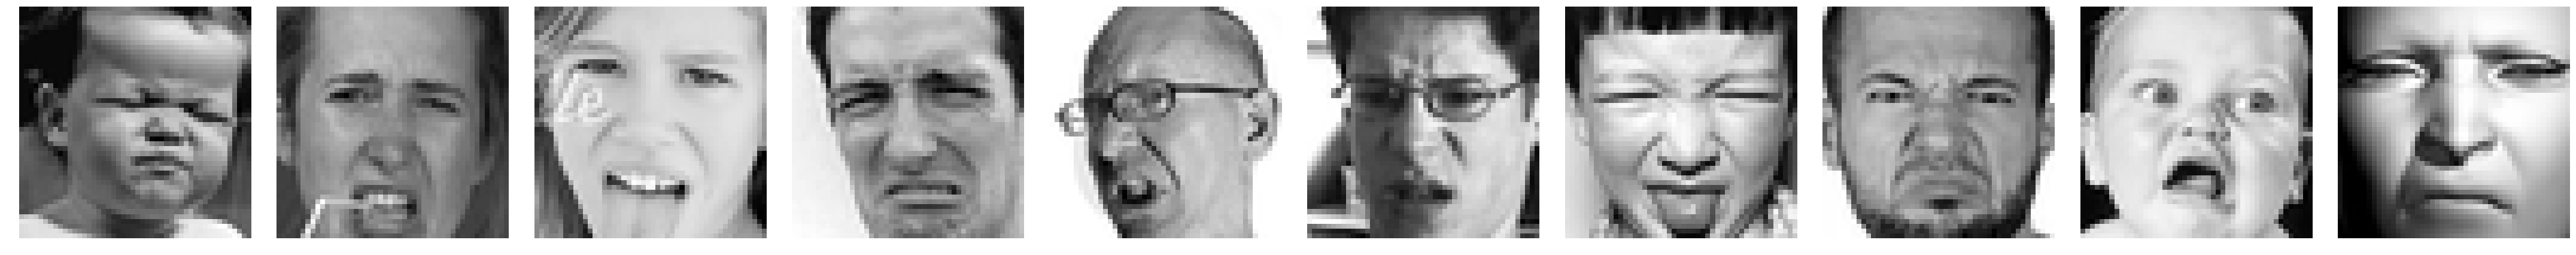

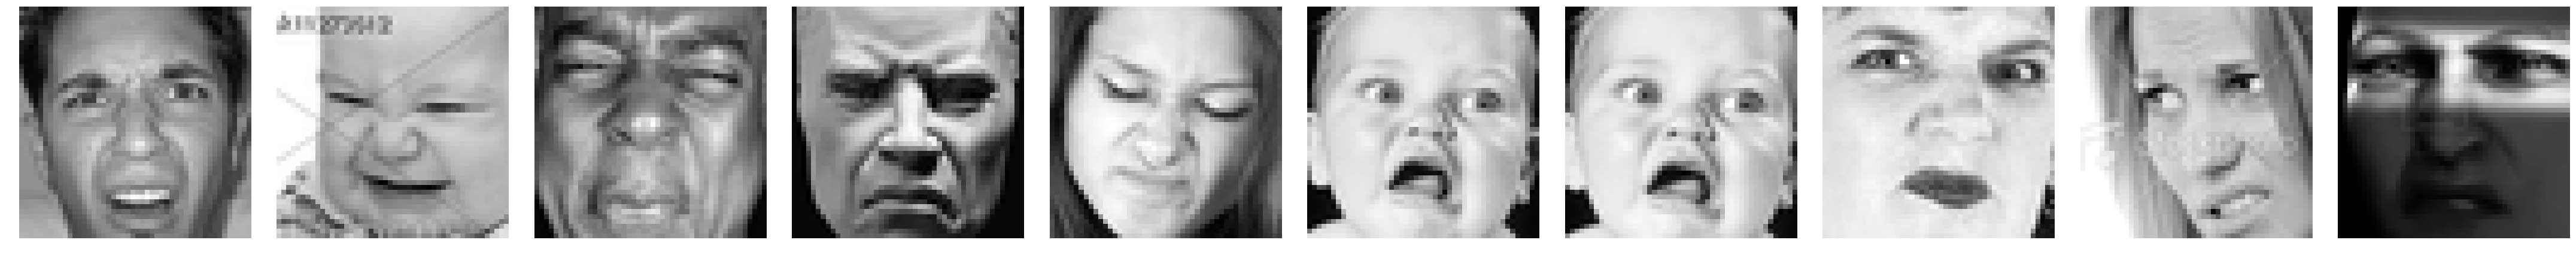

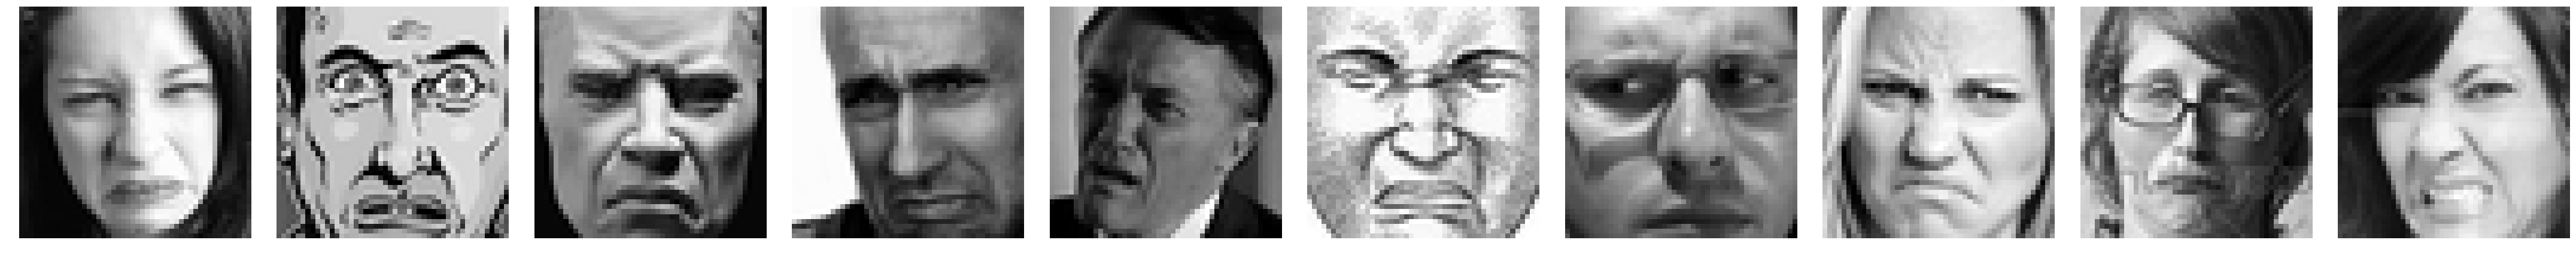

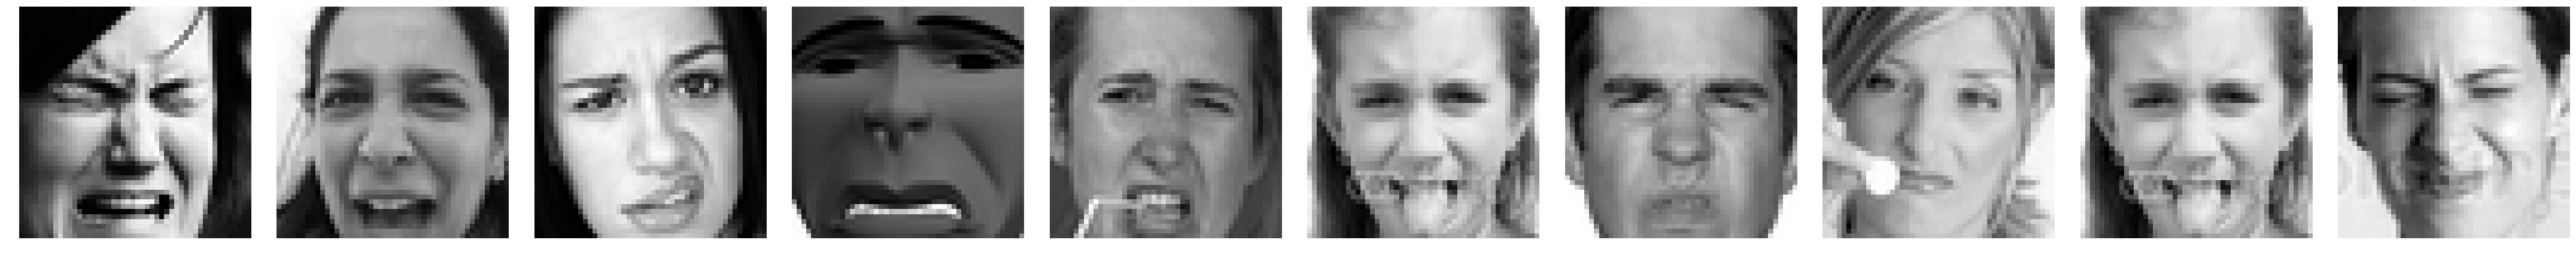

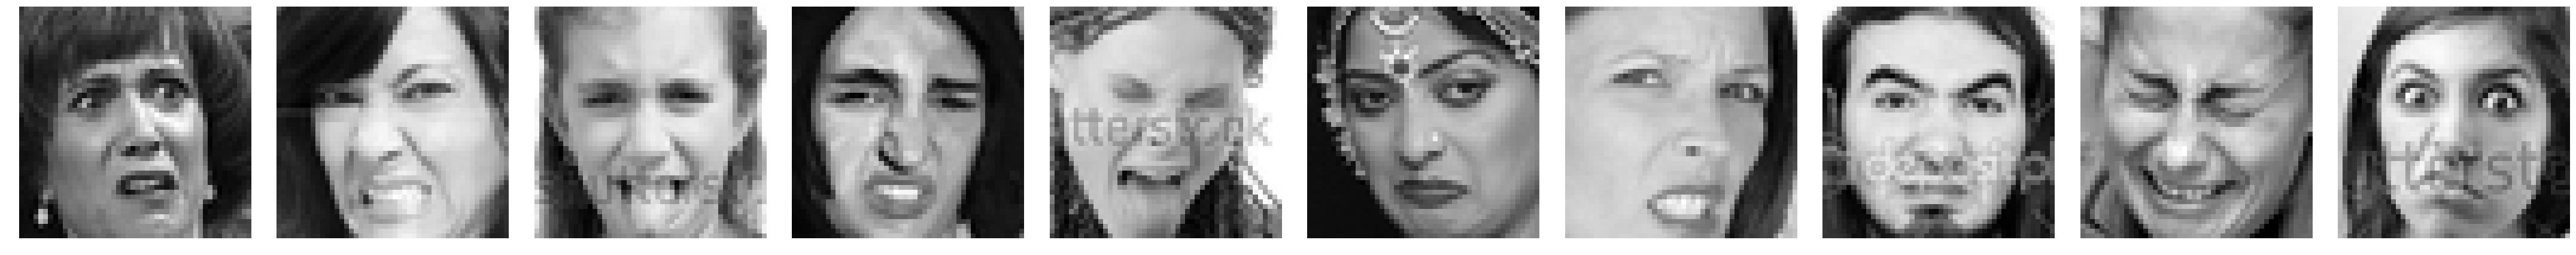

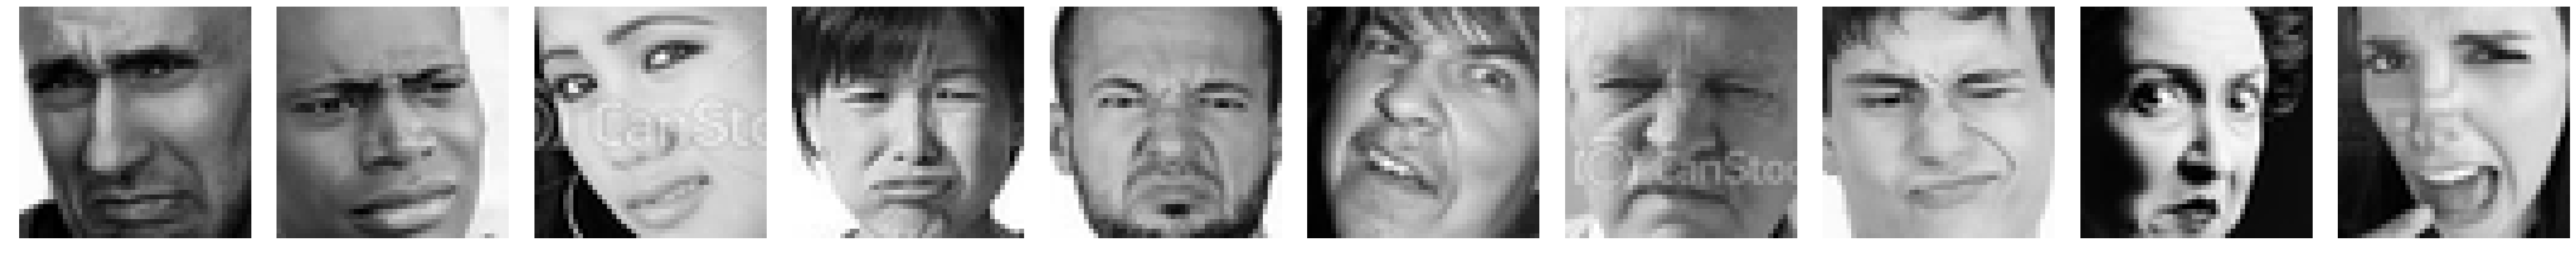

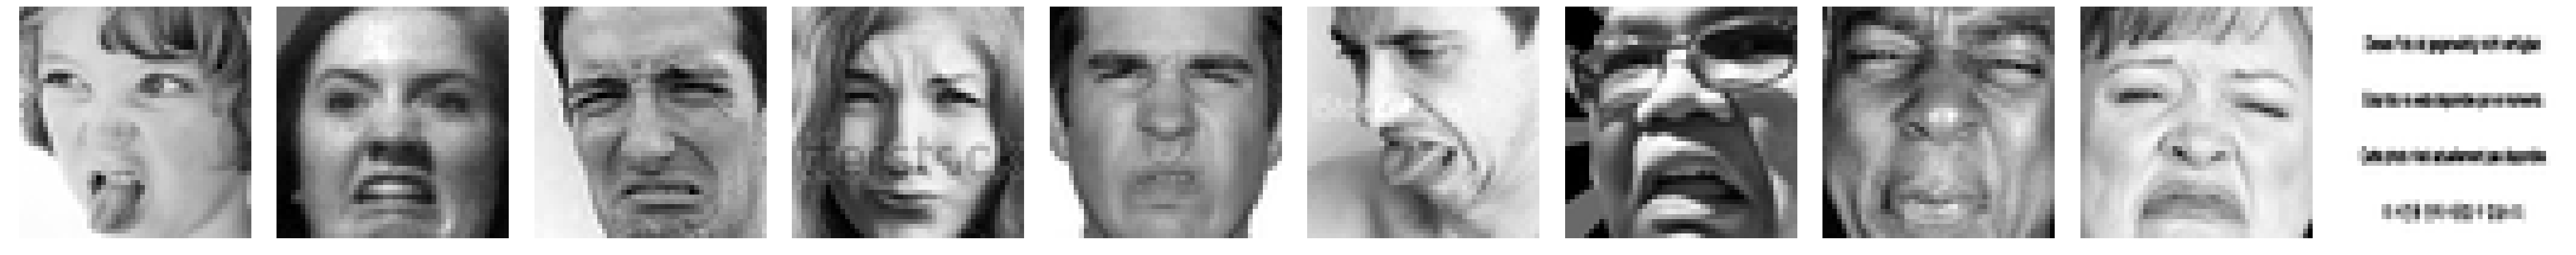

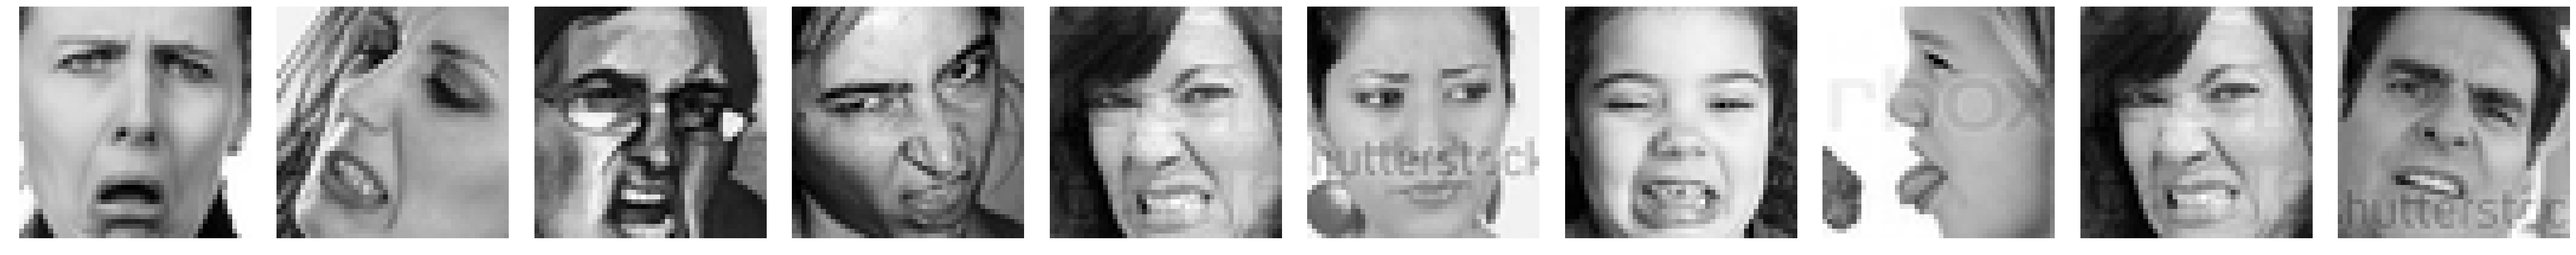


 Fear (subset of 100 imgs)------------------


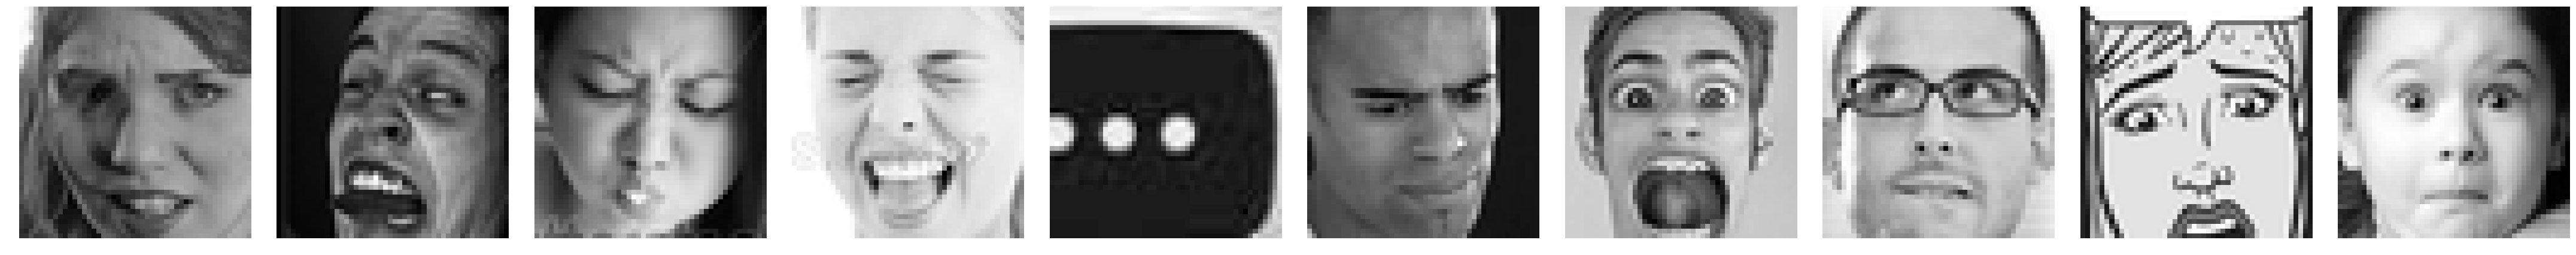

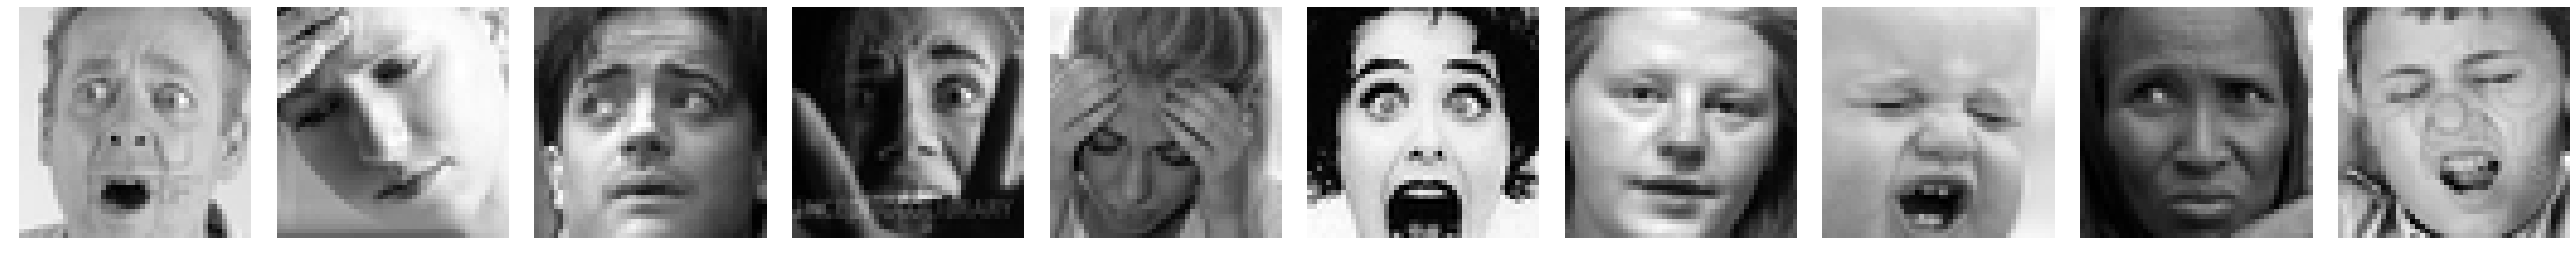

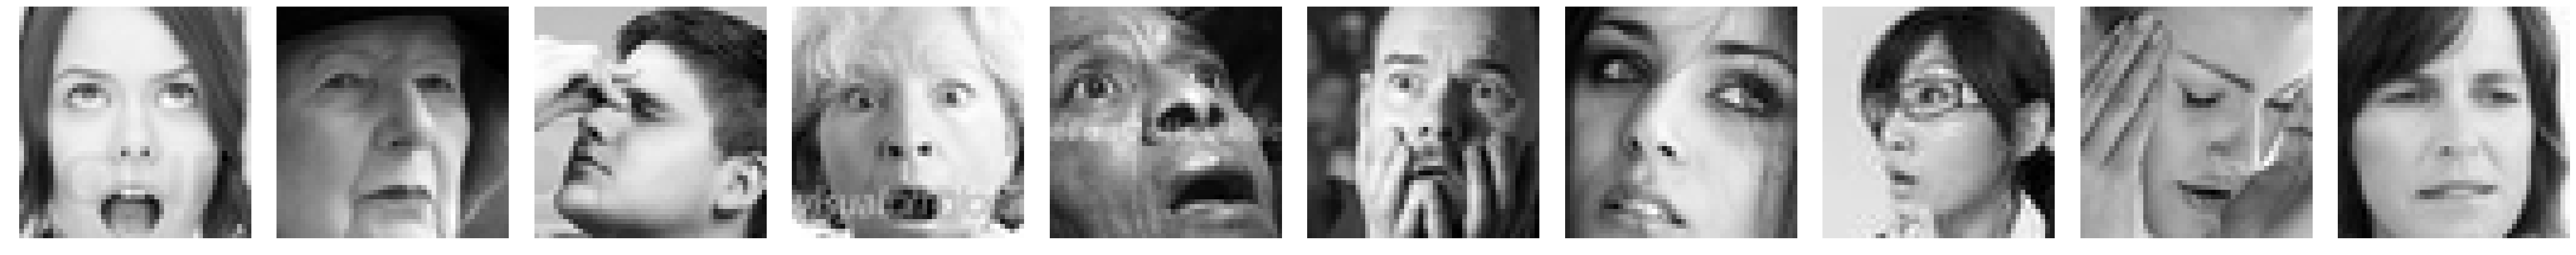

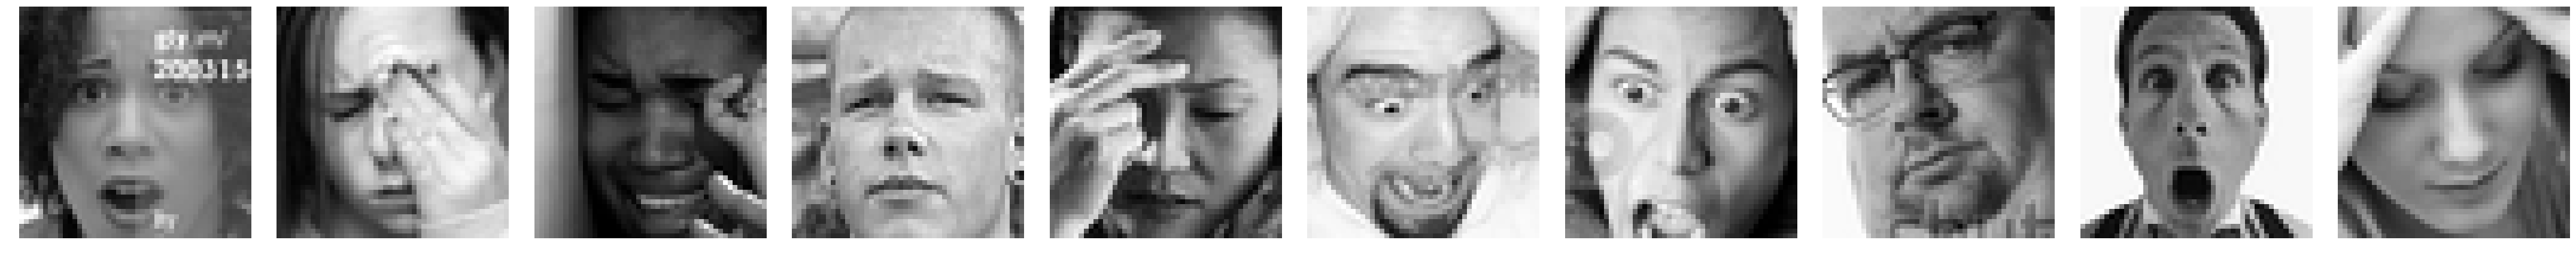

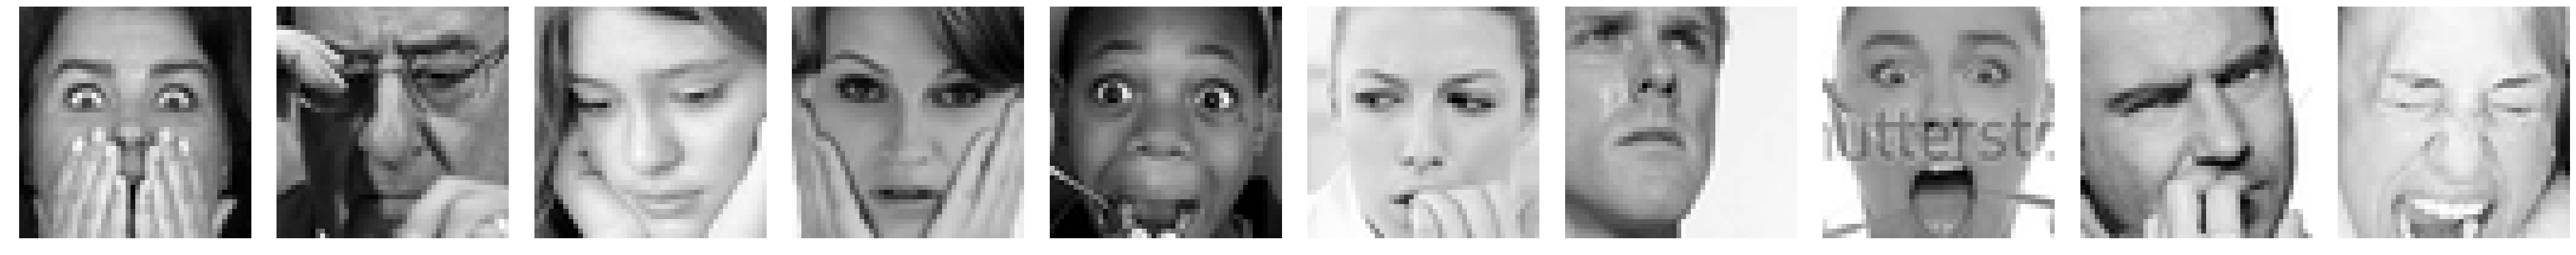

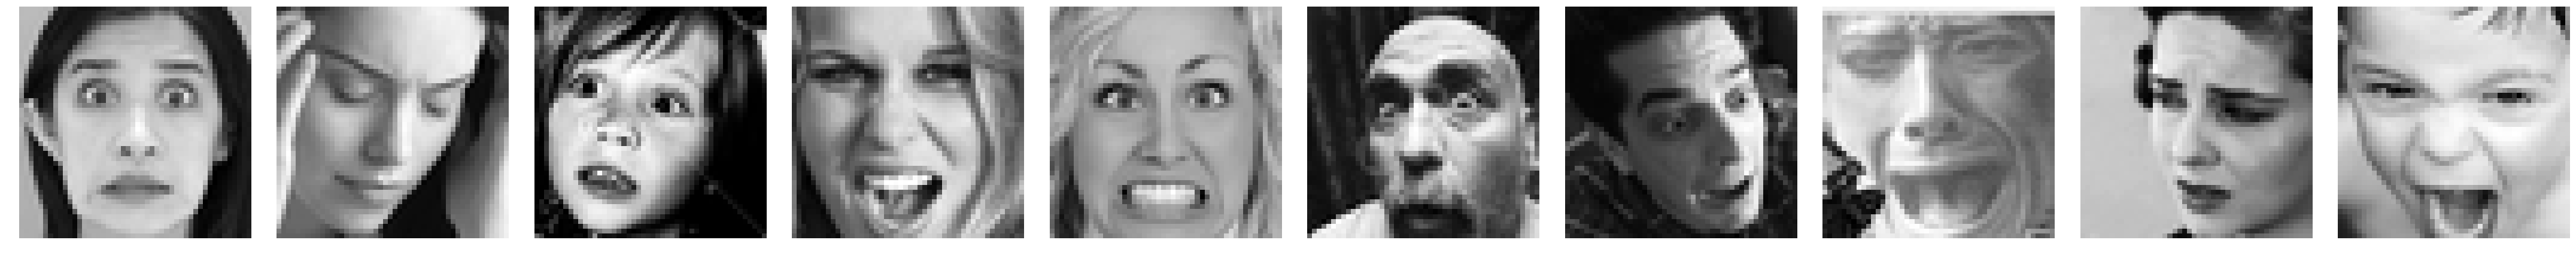

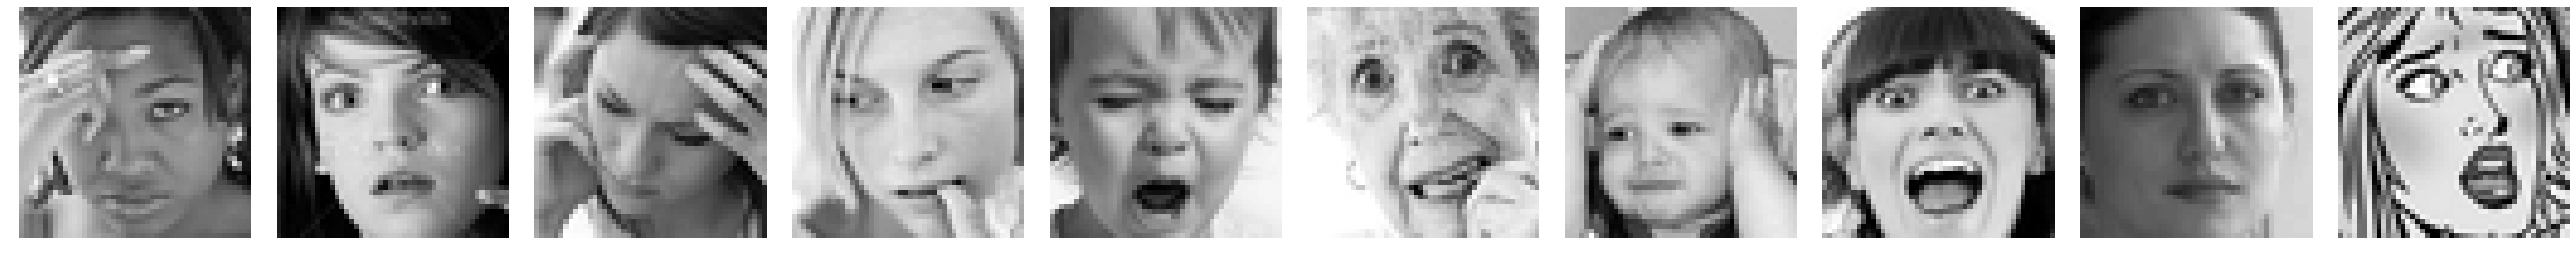

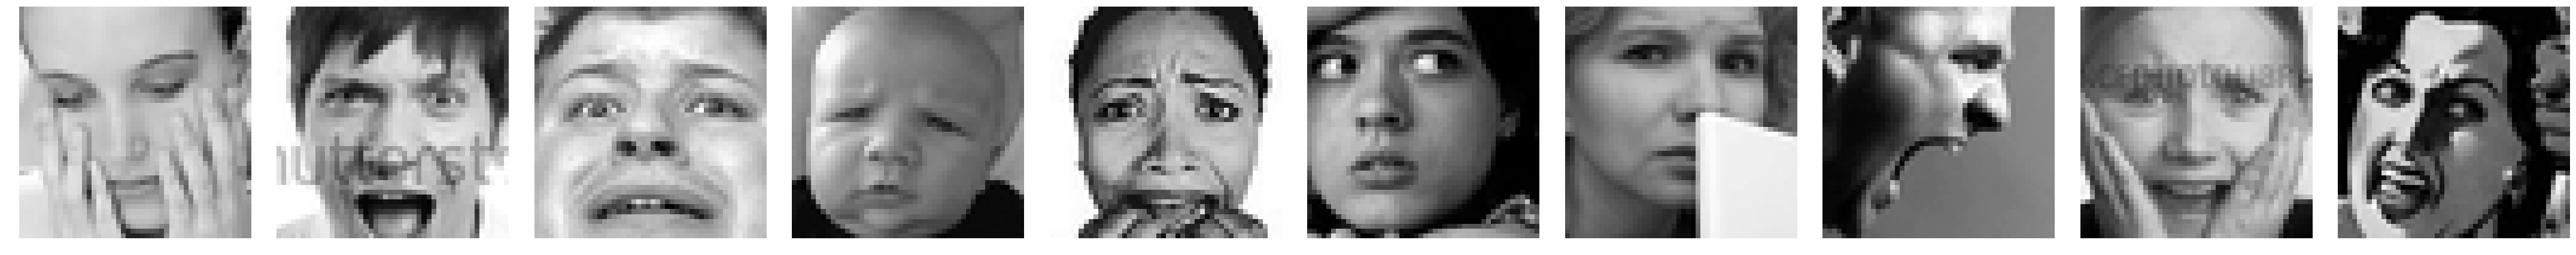

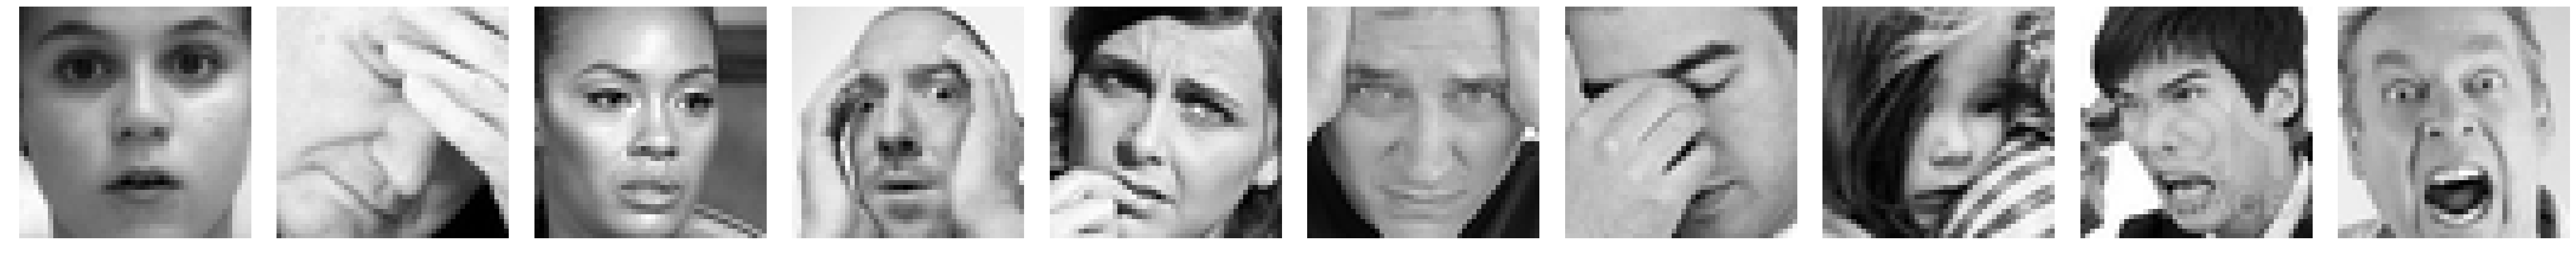

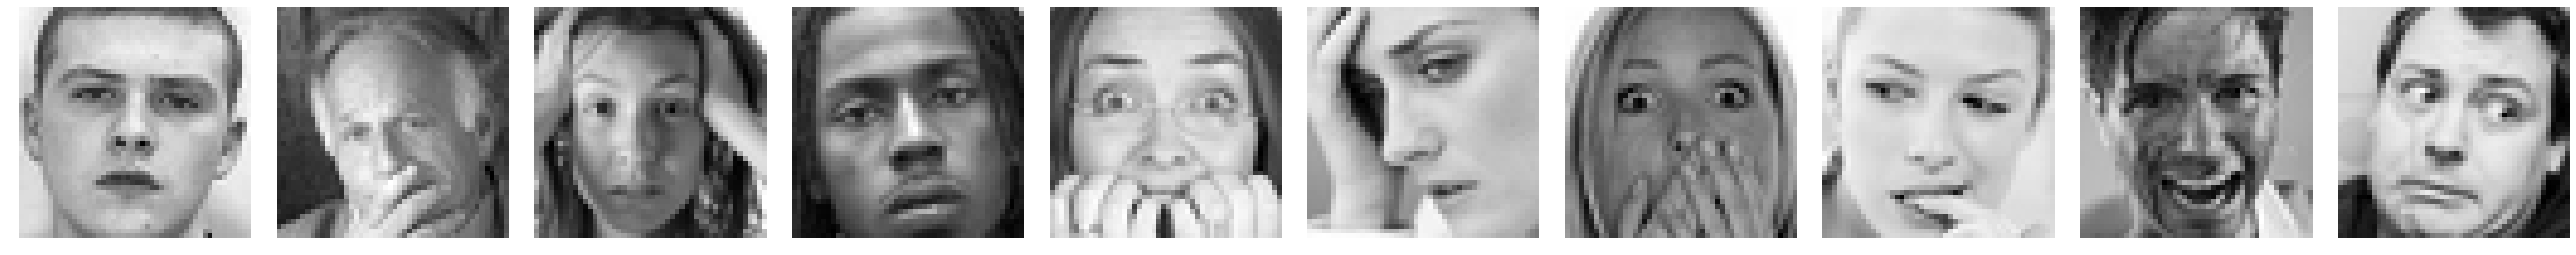


 Happy (subset of 100 imgs)------------------


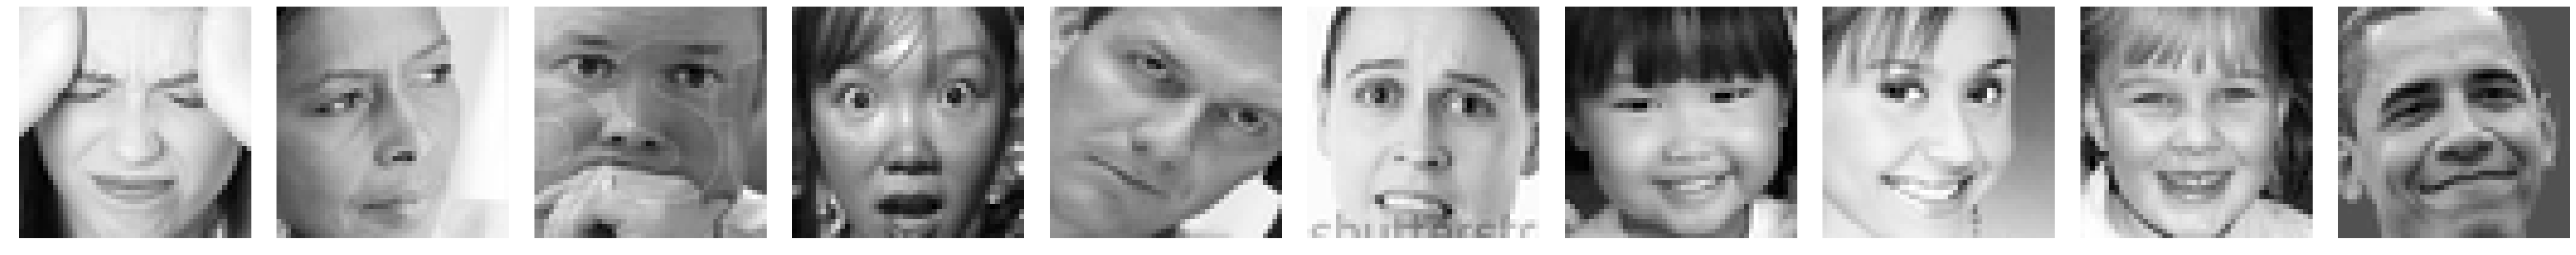

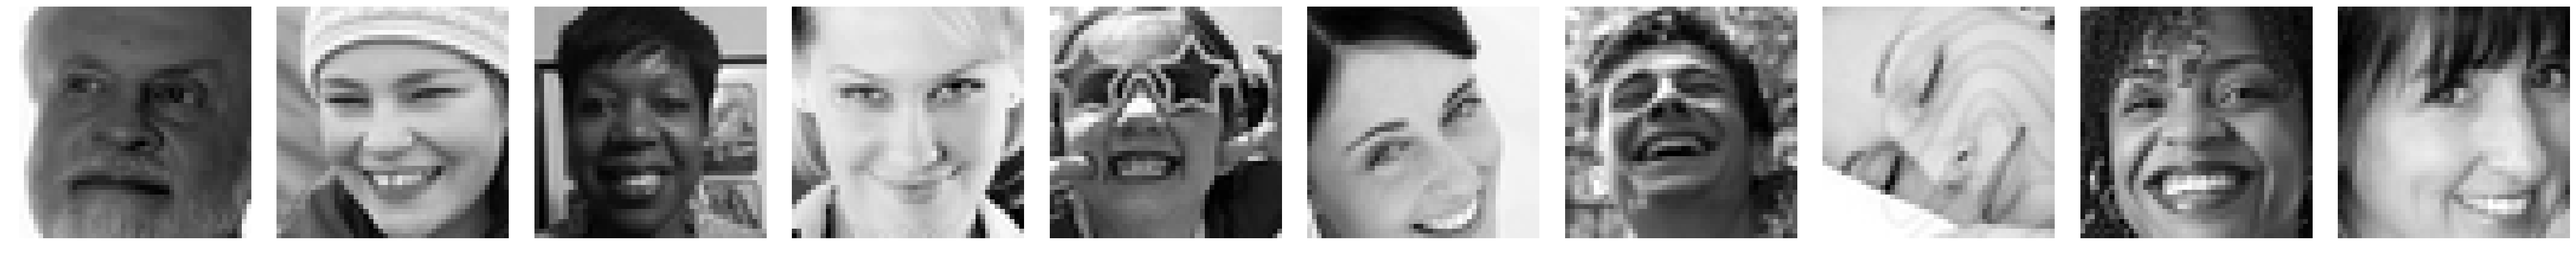

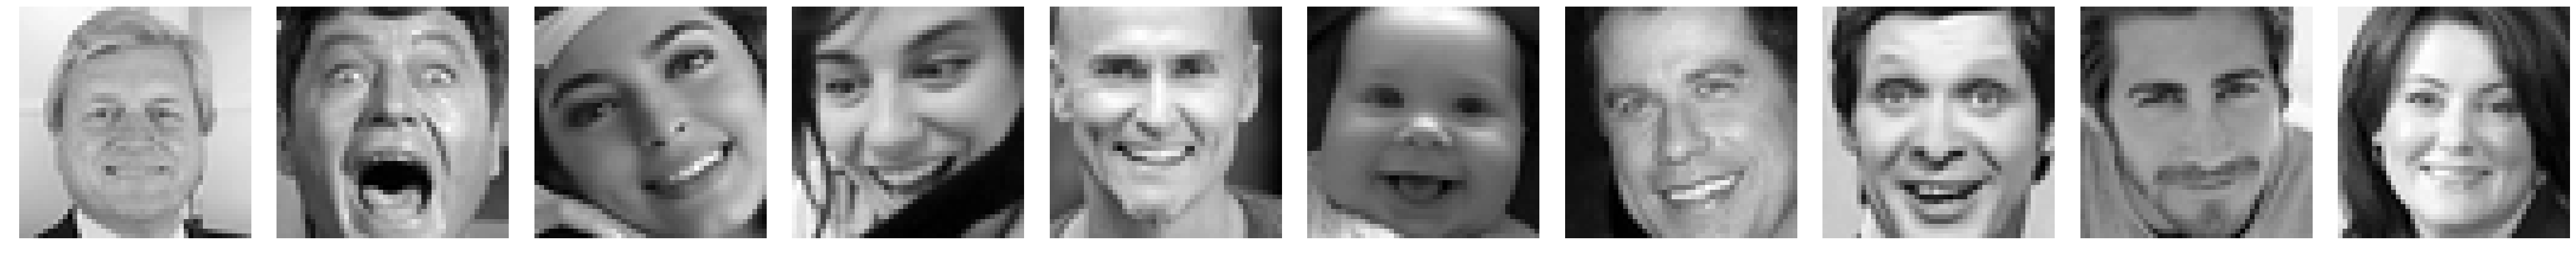

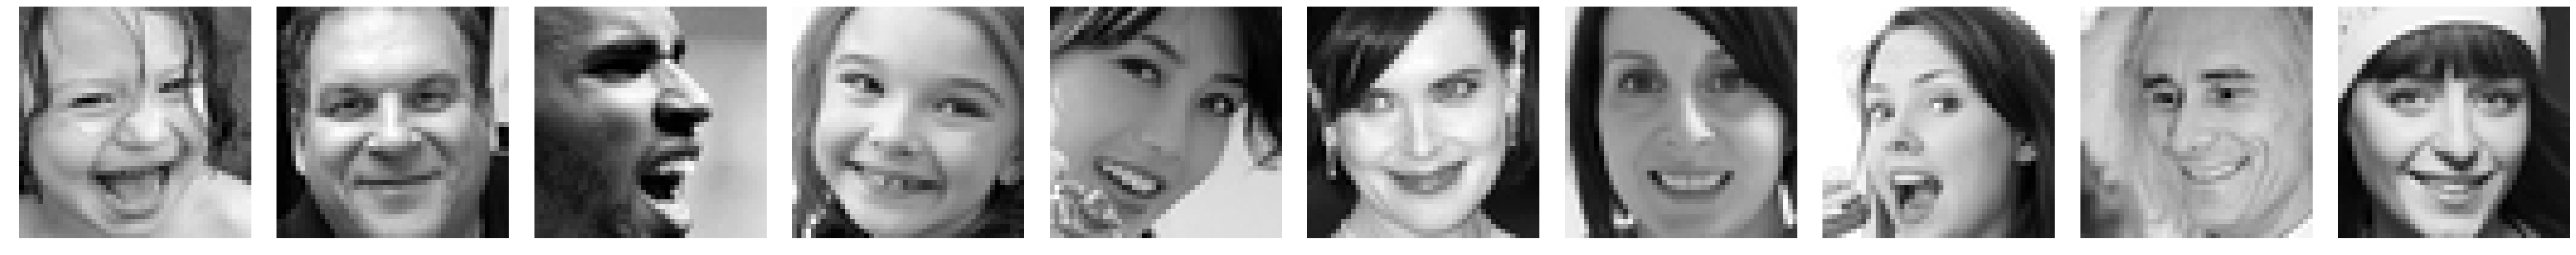

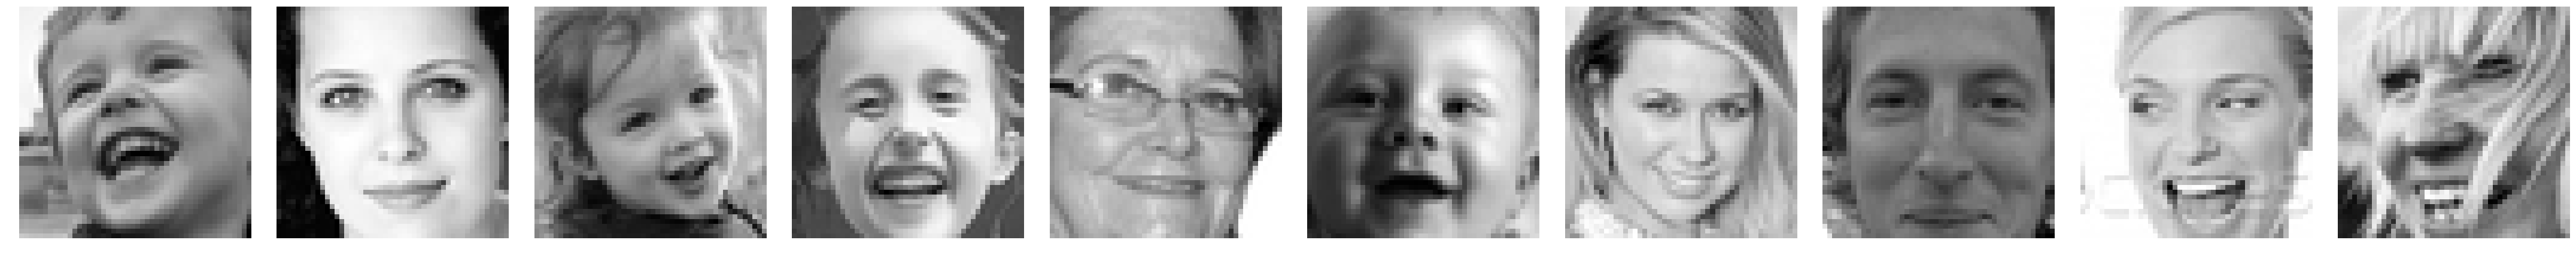

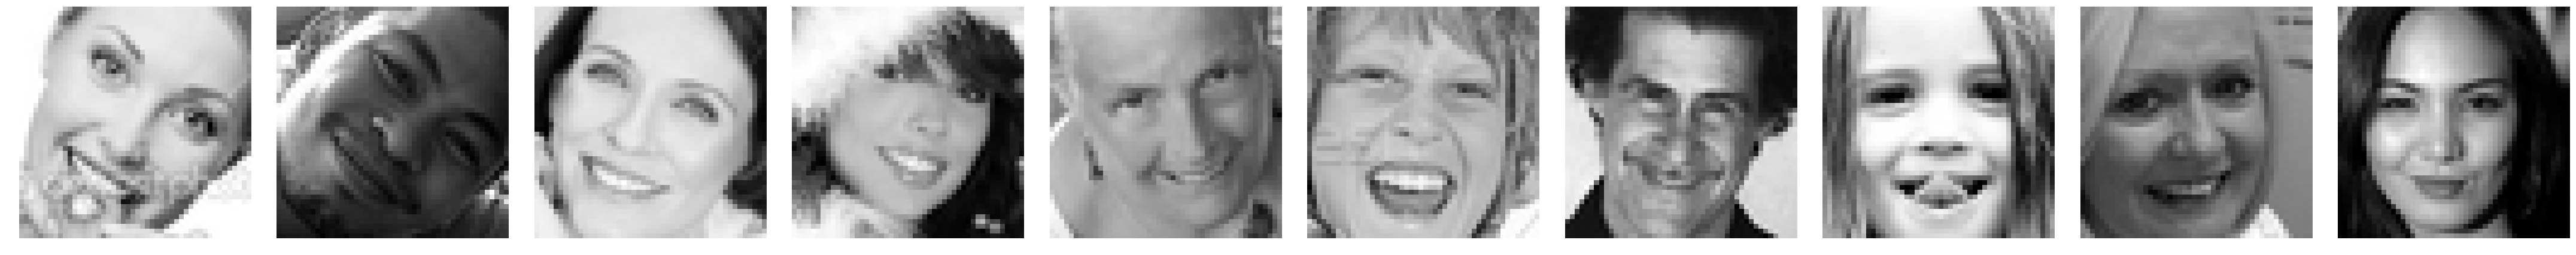

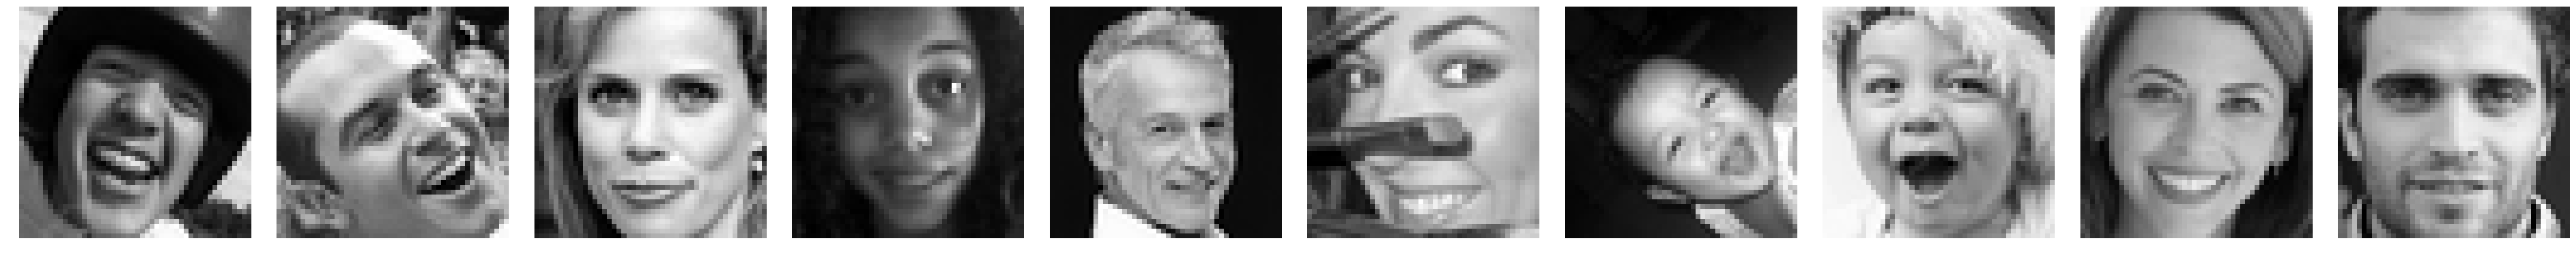

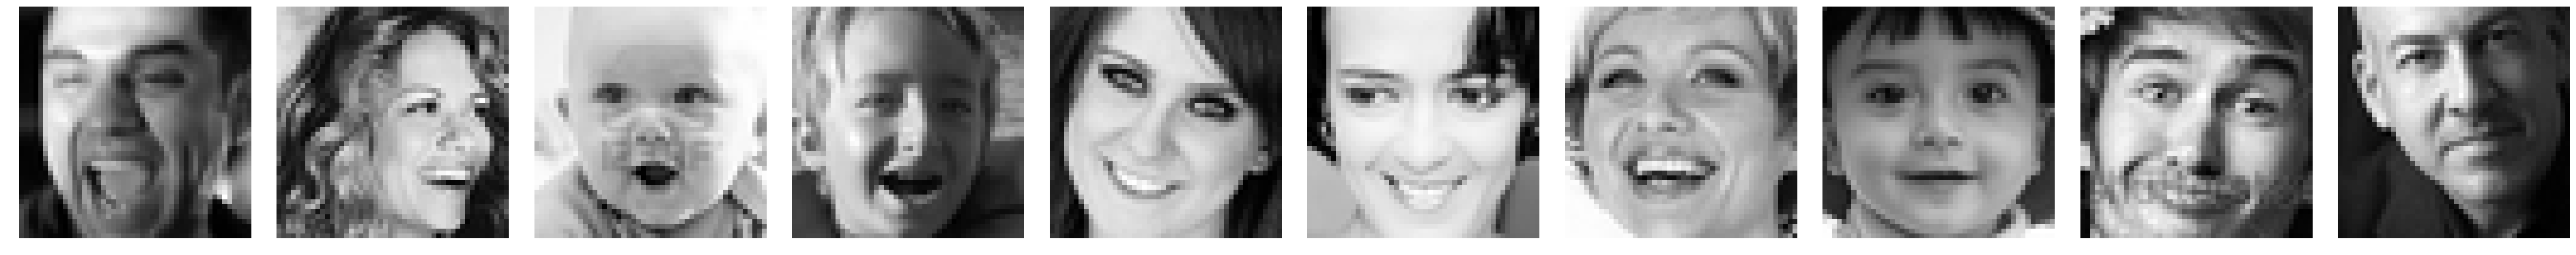

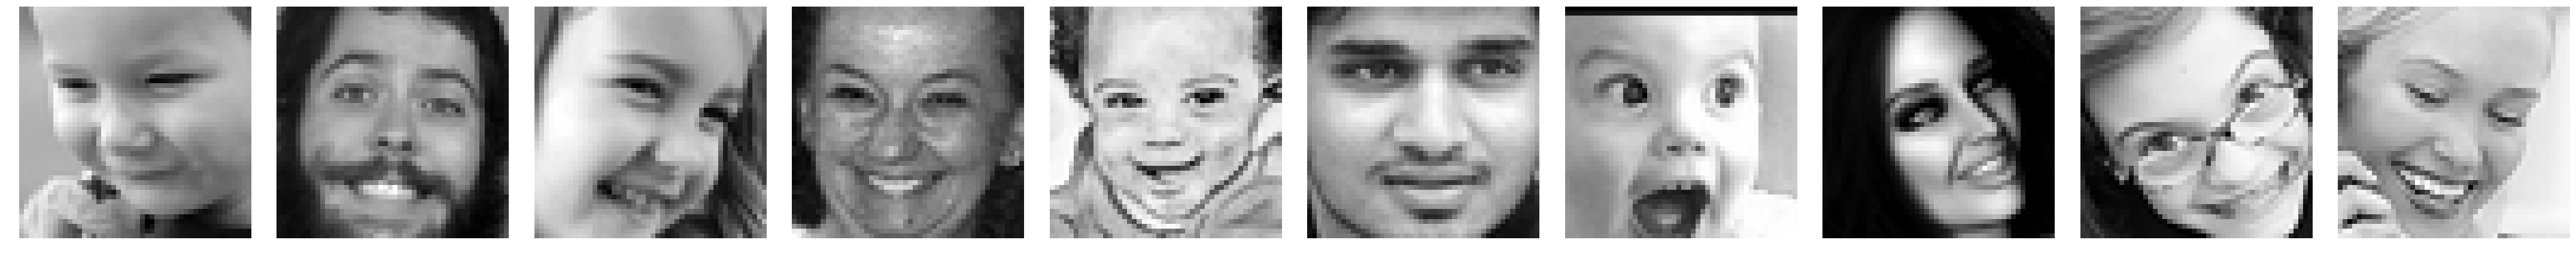

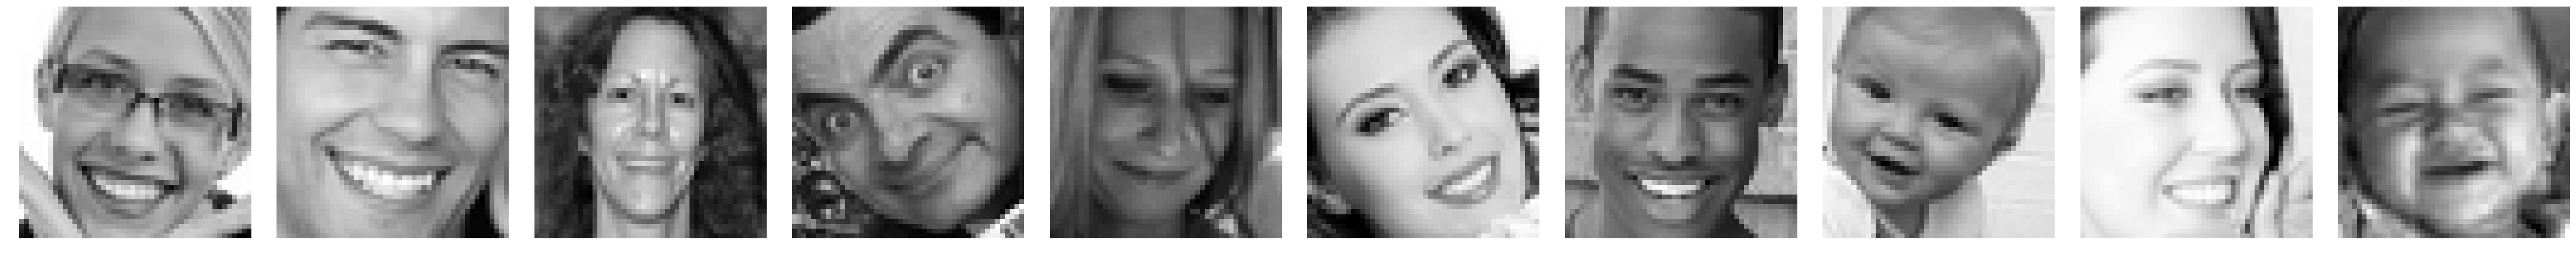


 Sad (subset of 100 imgs)------------------


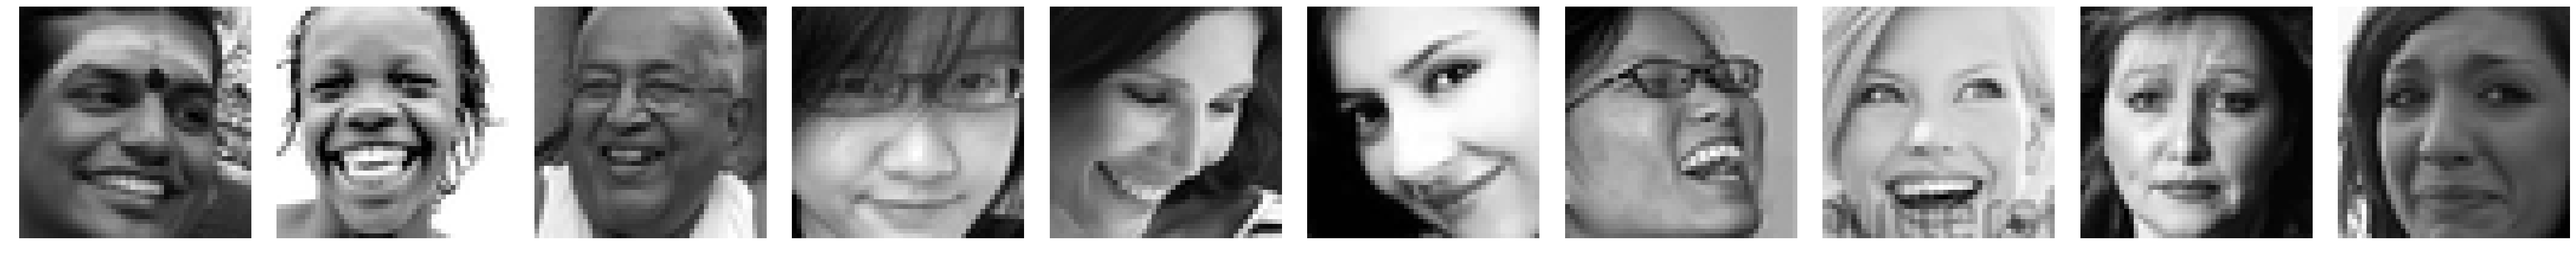

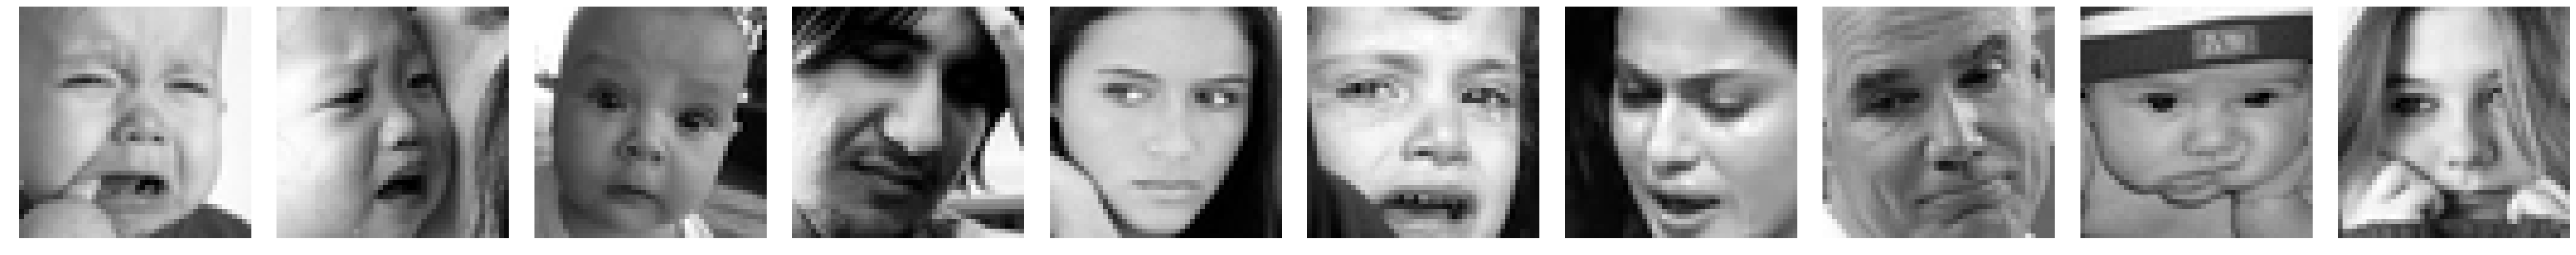

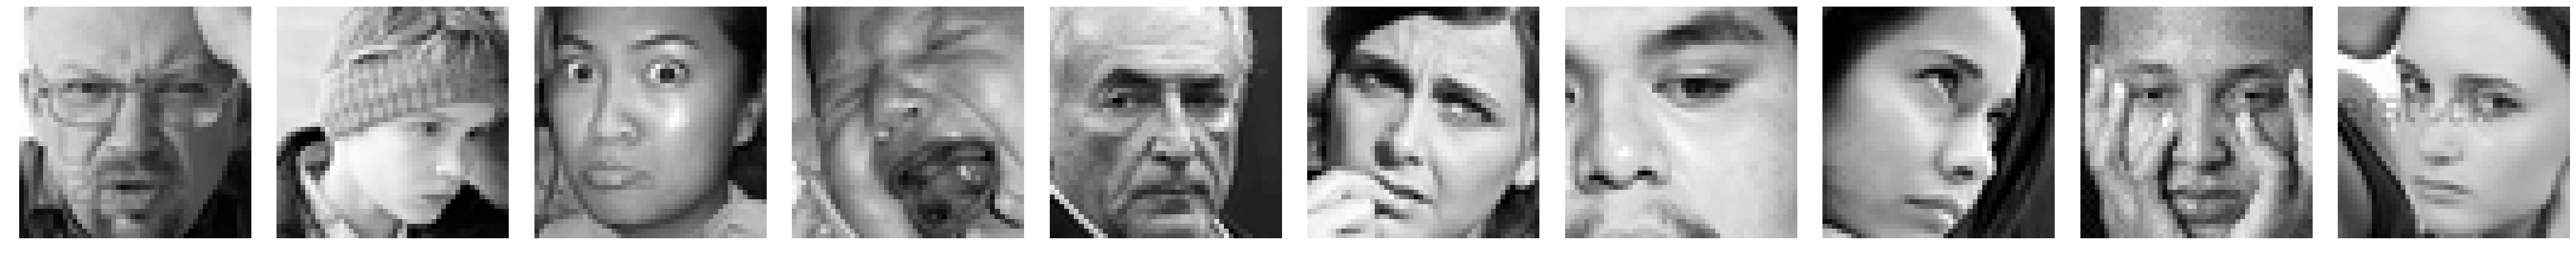

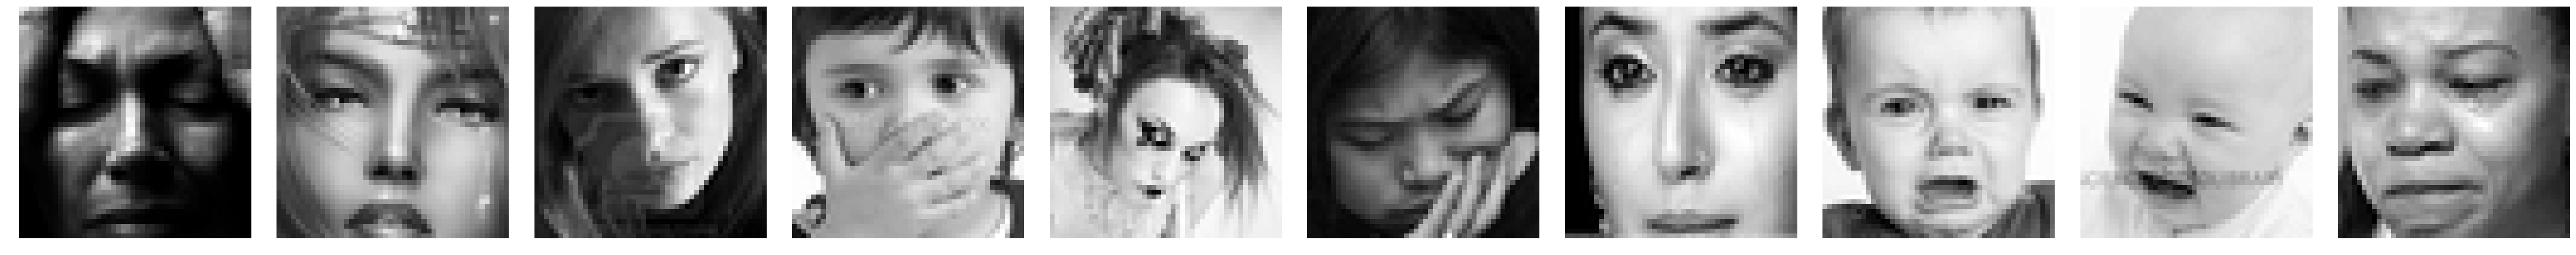

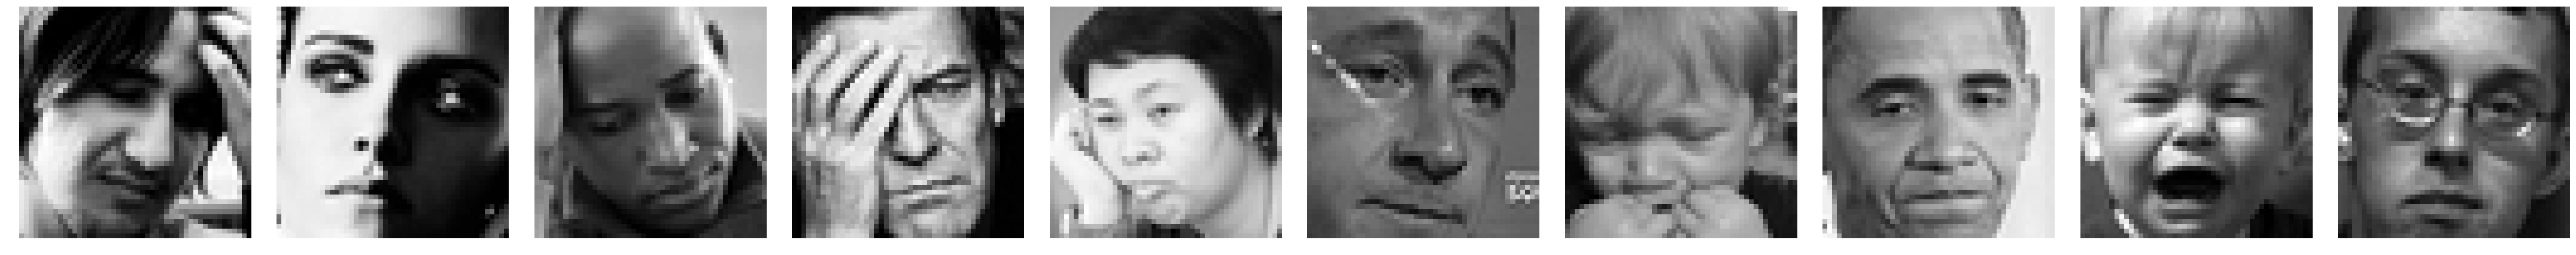

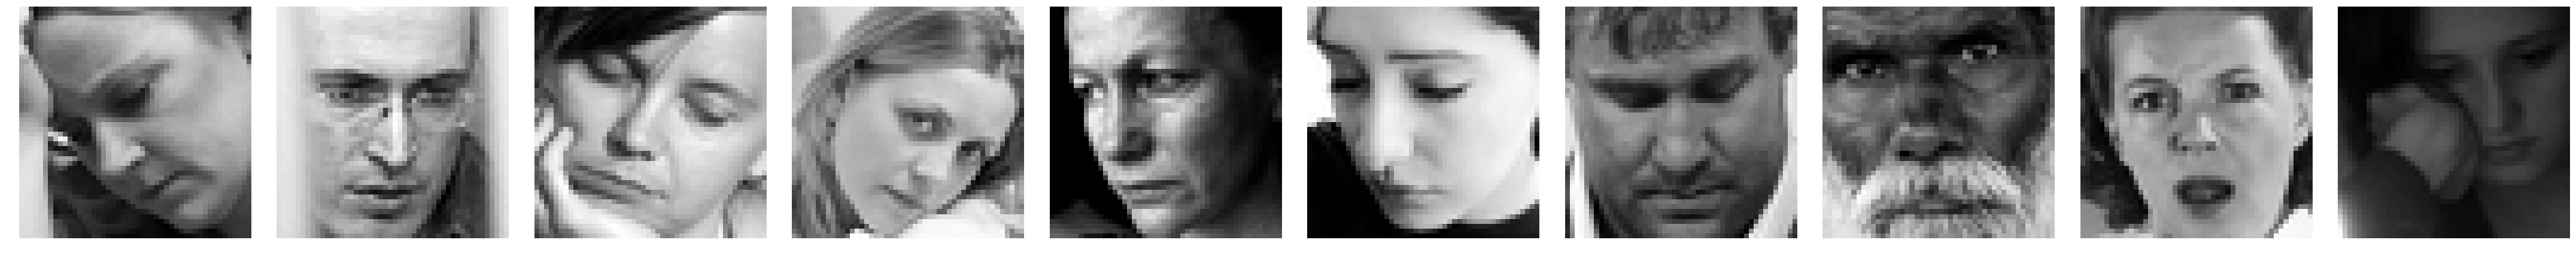

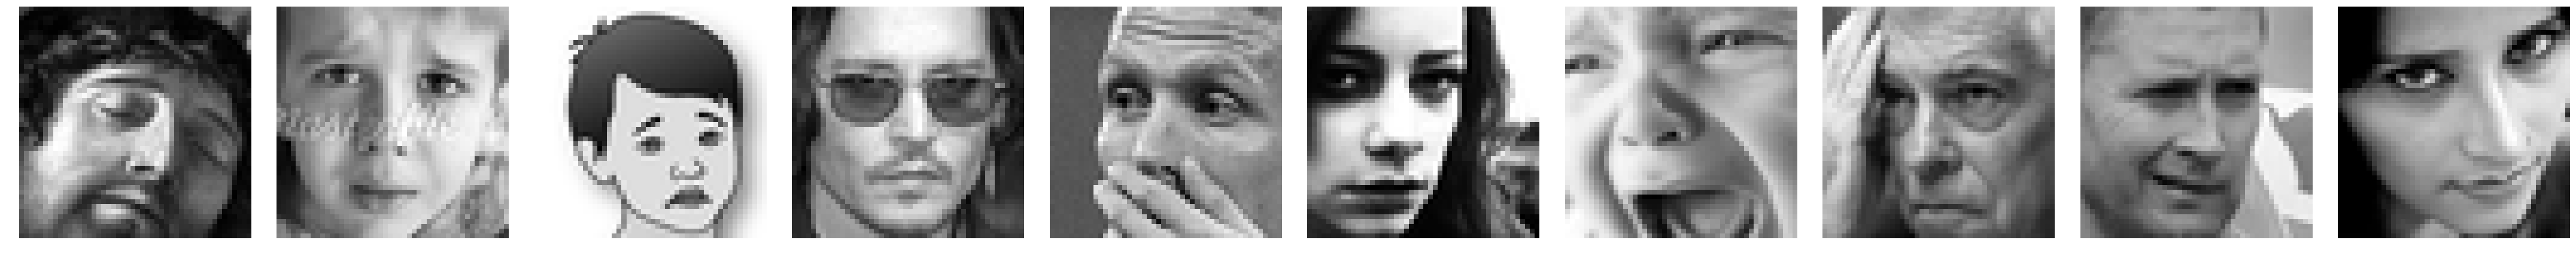

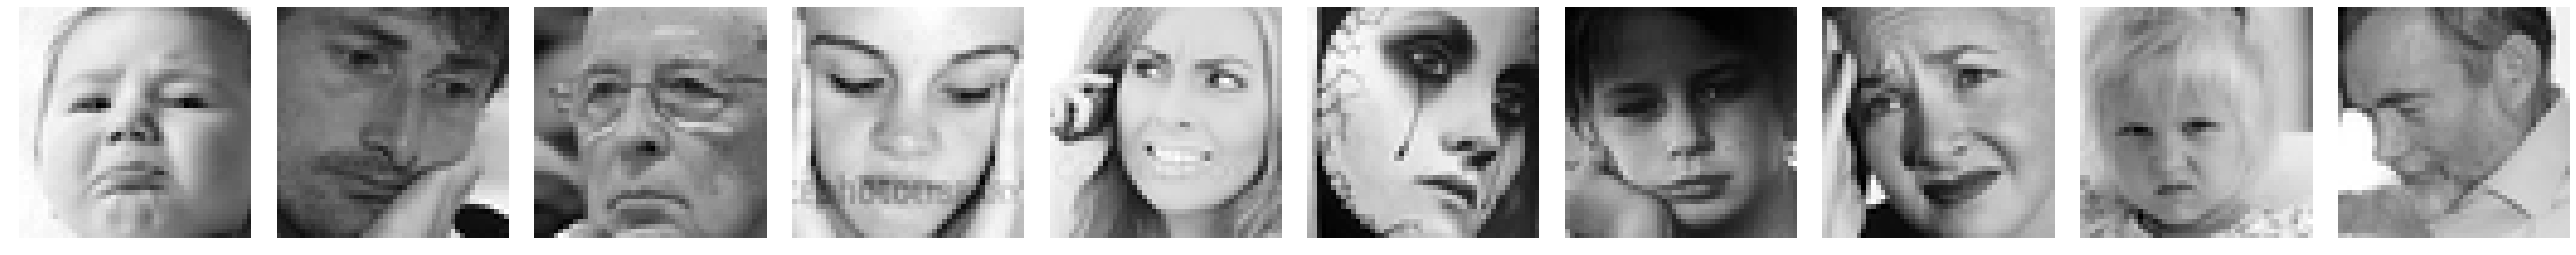

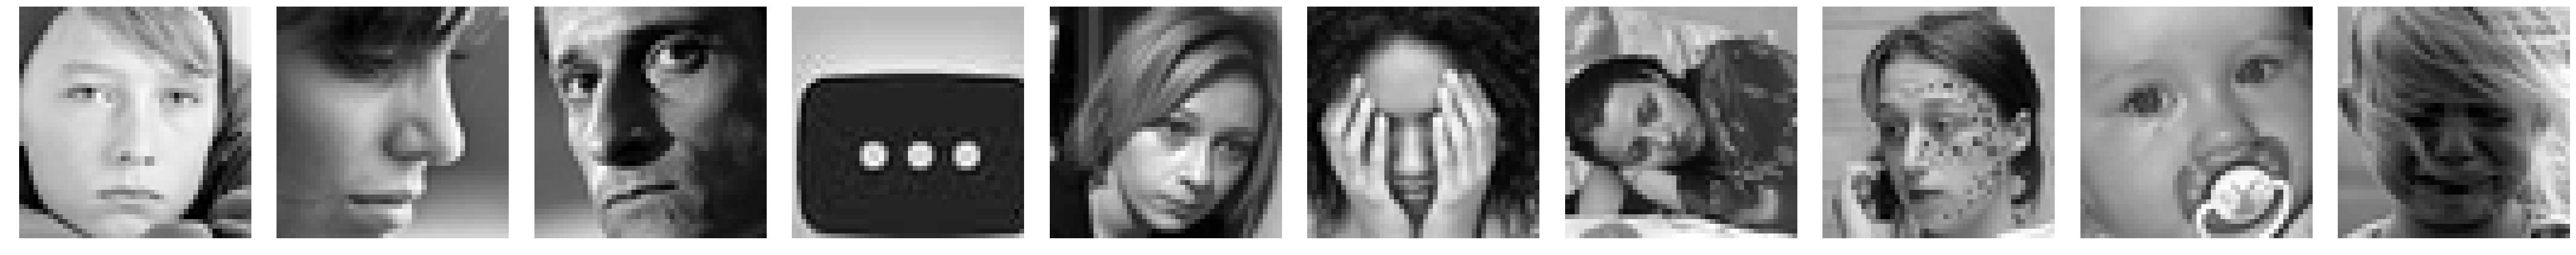

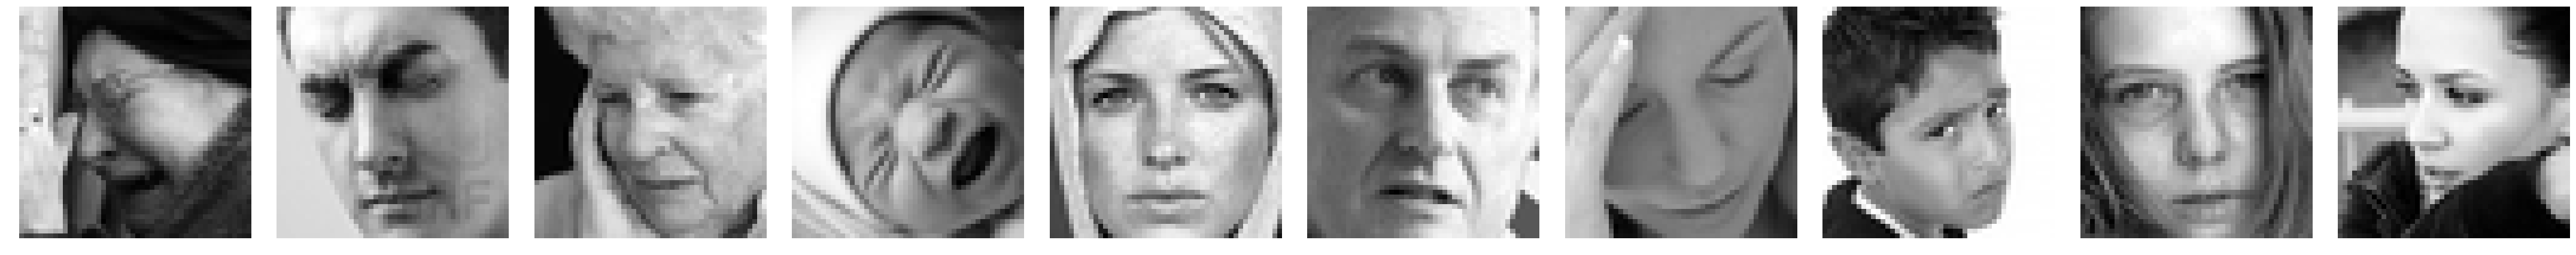


 Surprise (subset of 100 imgs)------------------


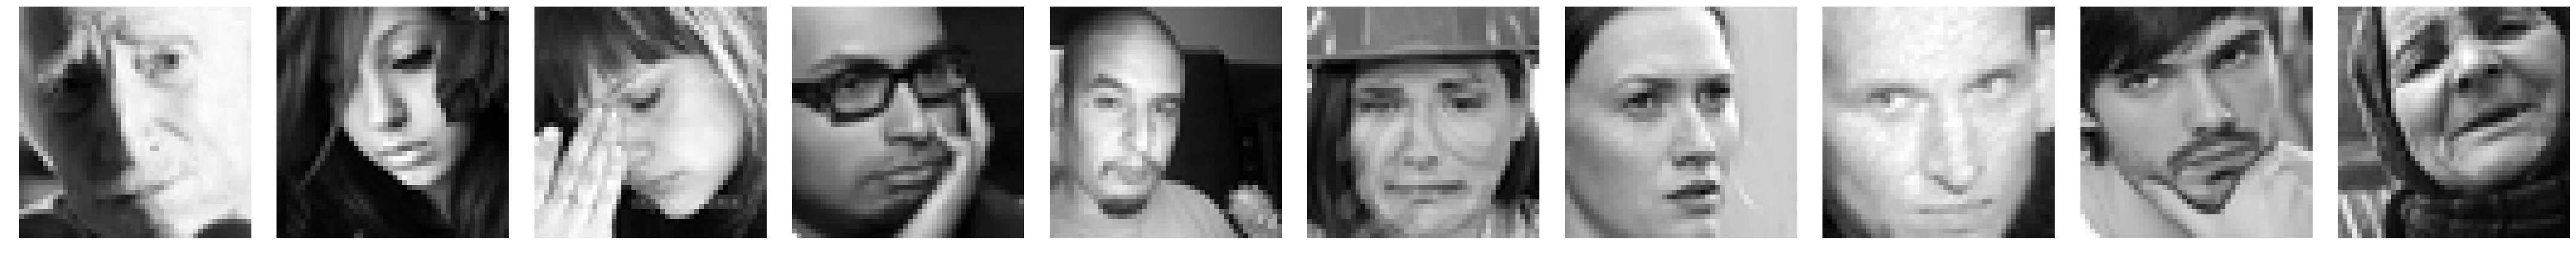

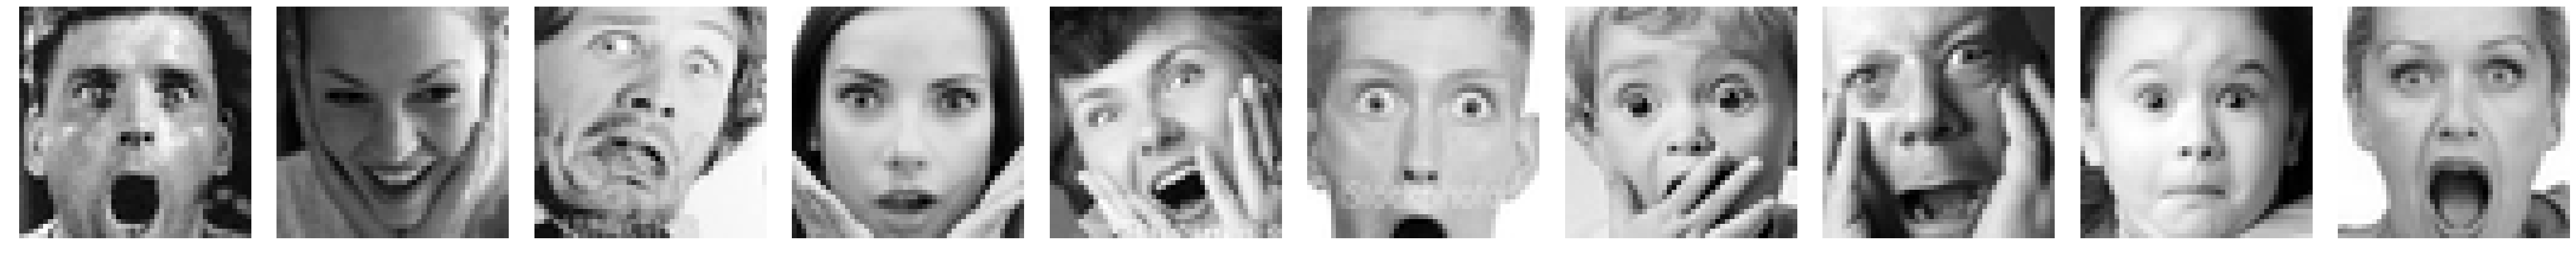

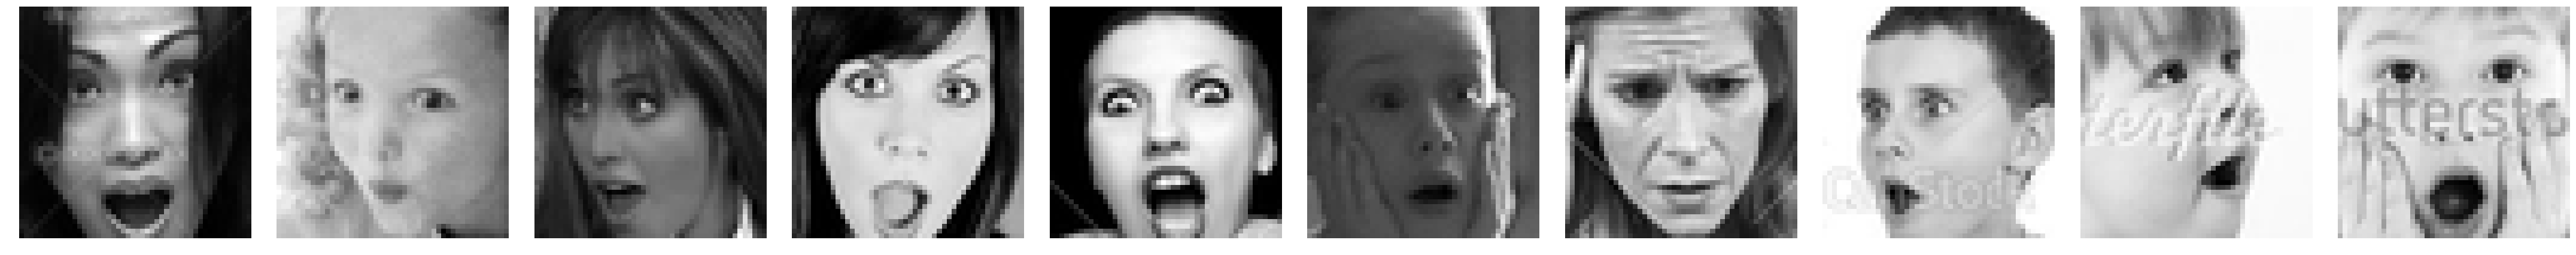

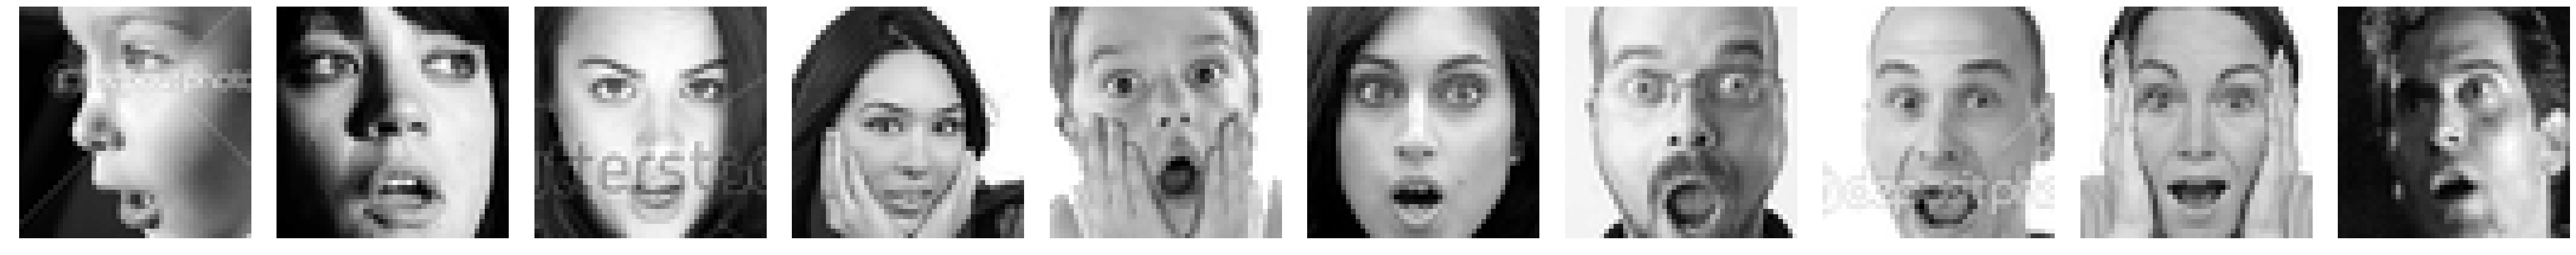

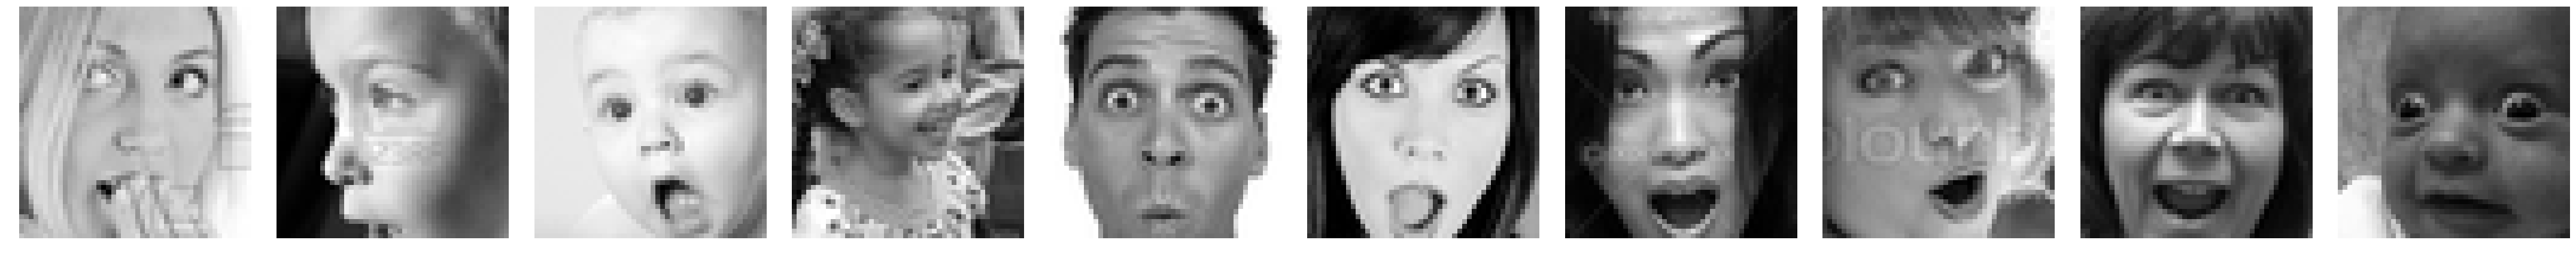

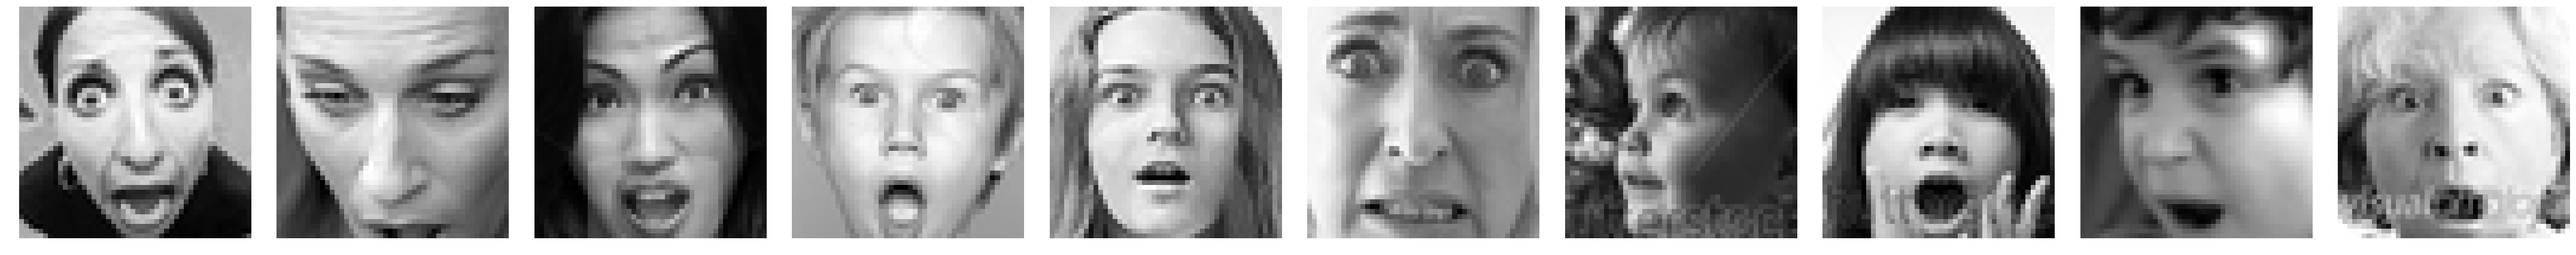

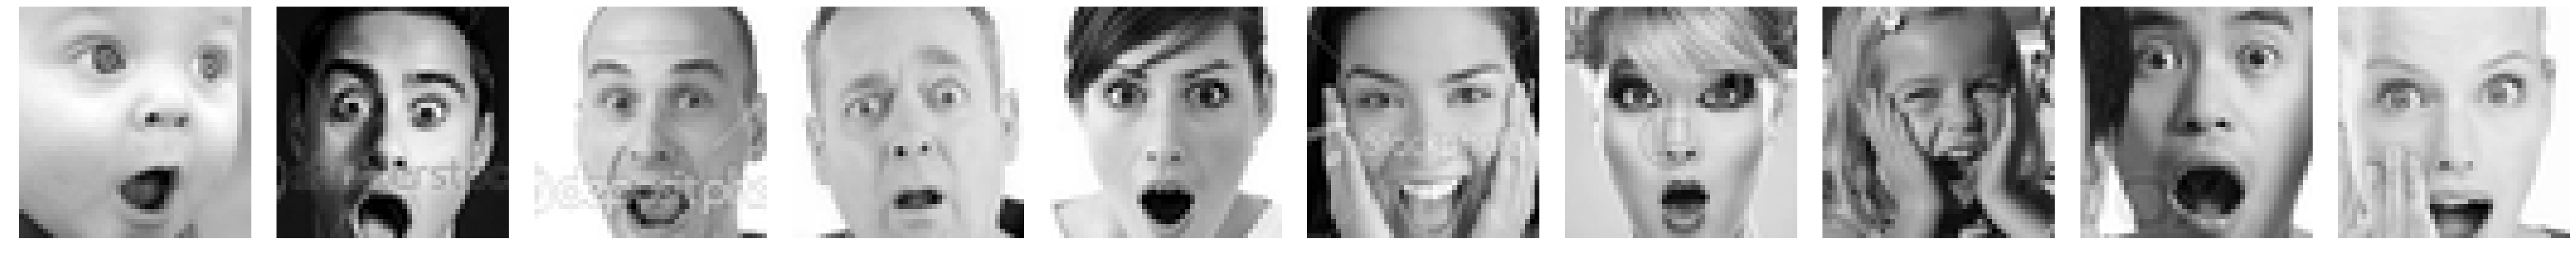

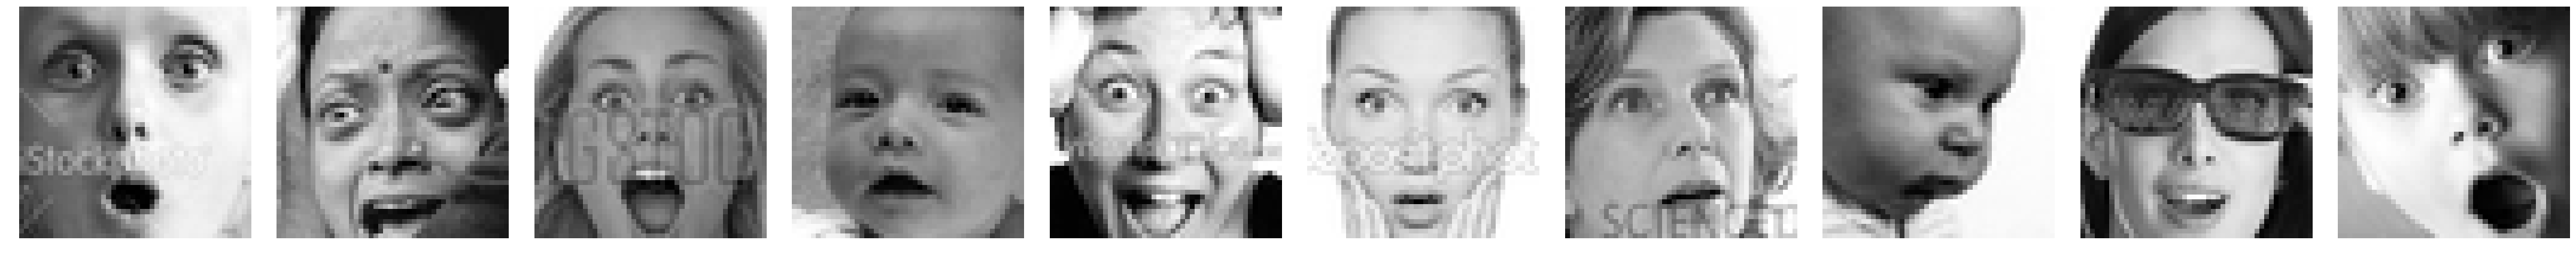

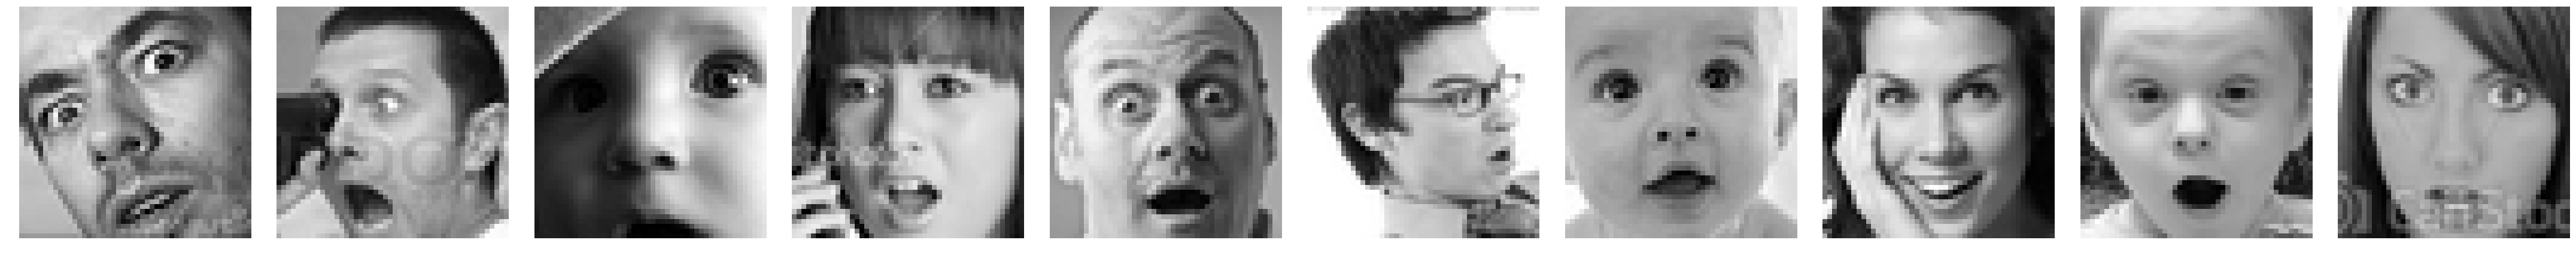

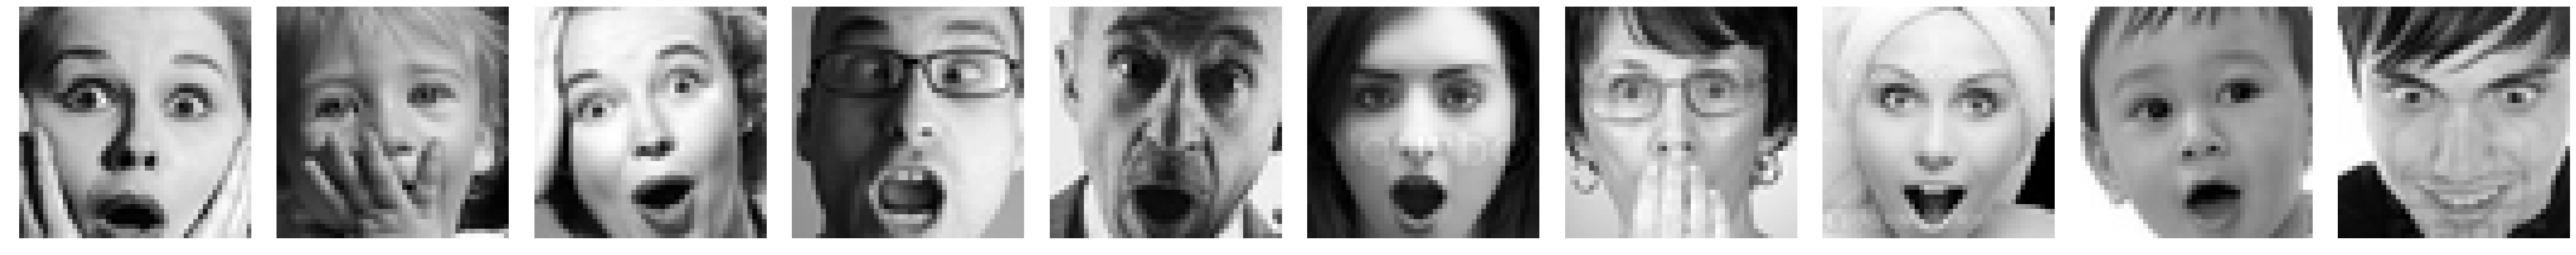

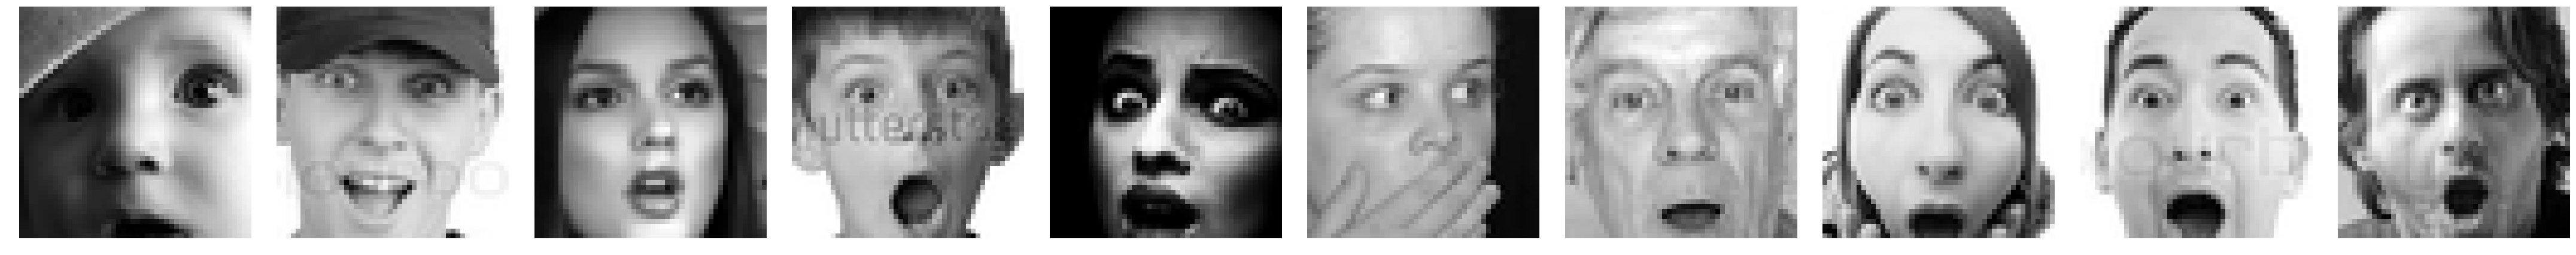


 Neutral (subset of 100 imgs)------------------


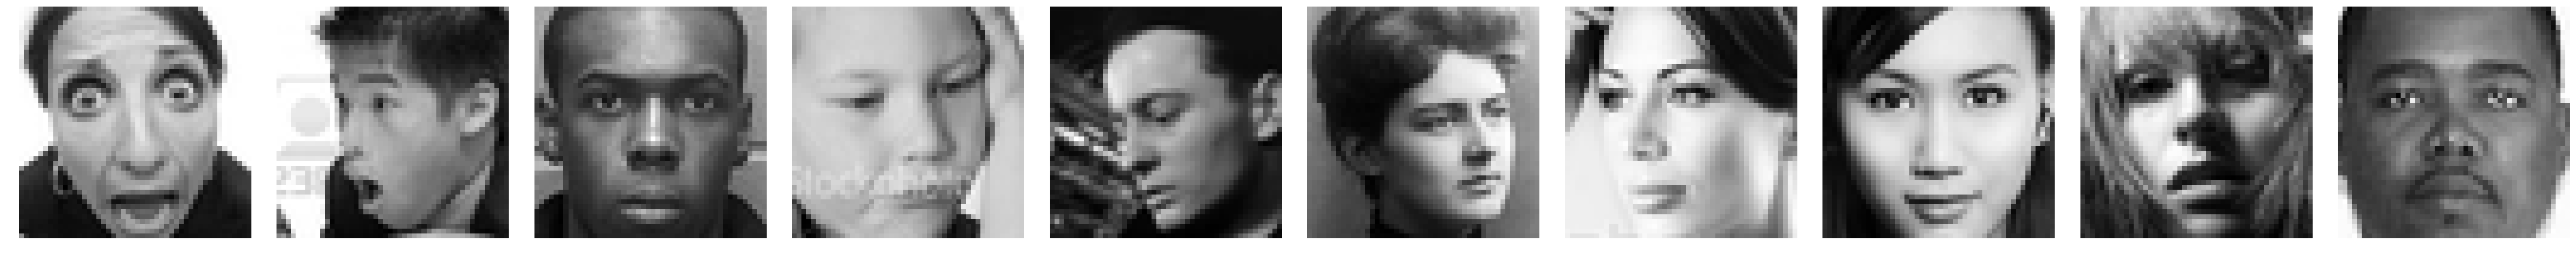

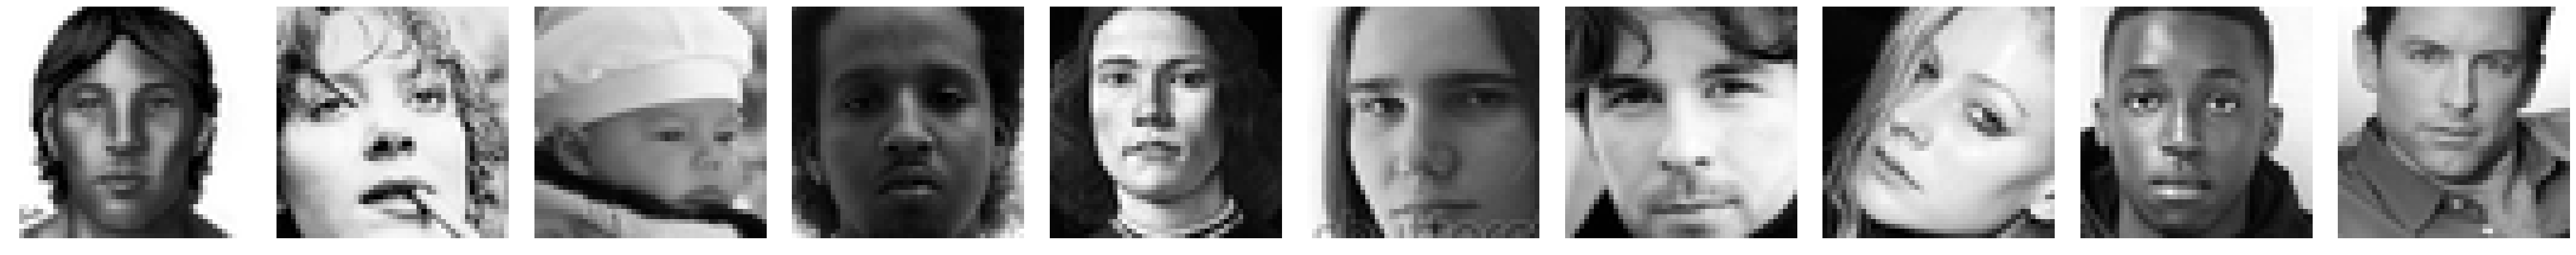

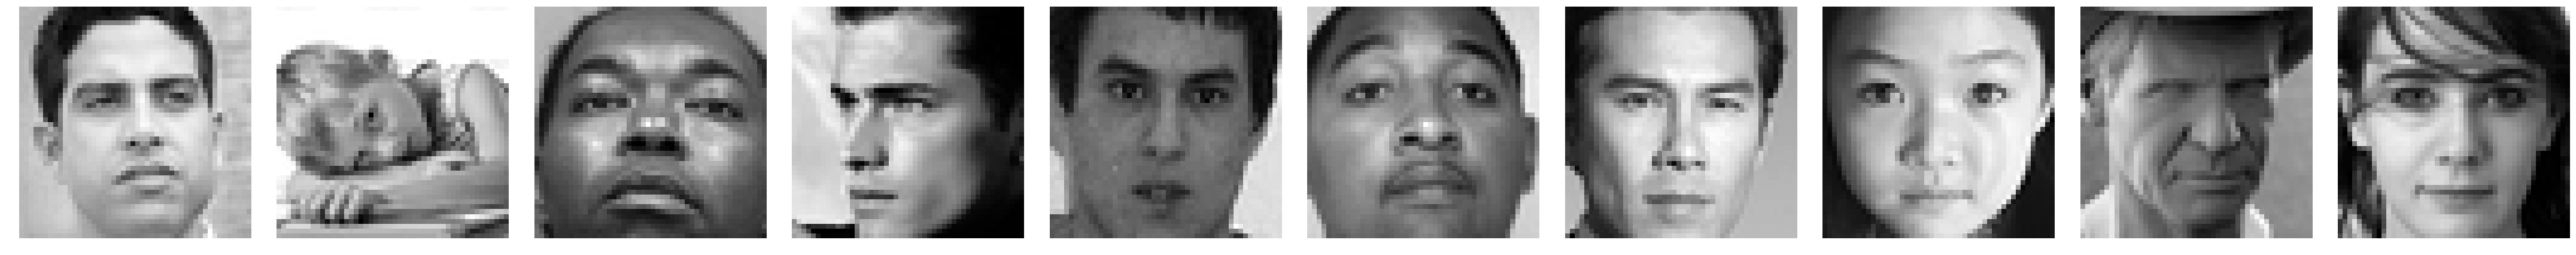

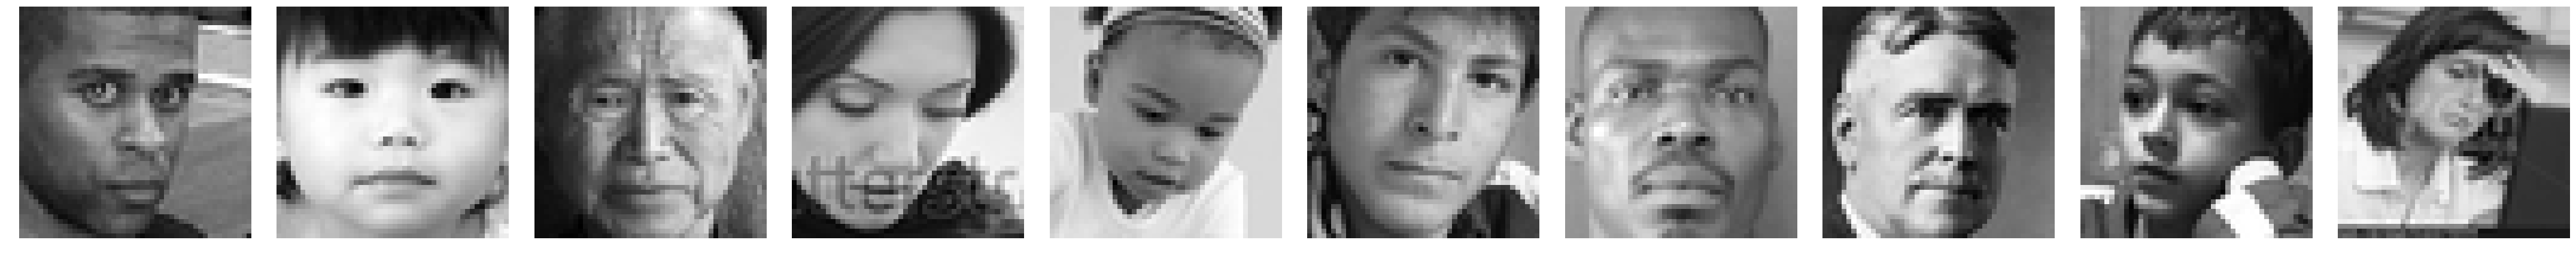

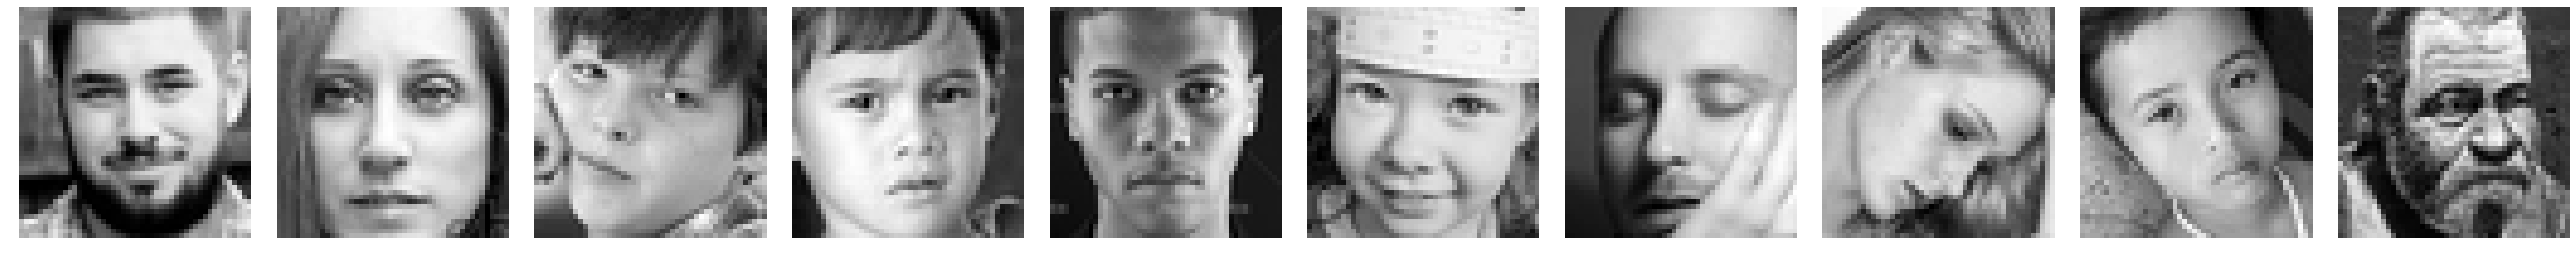

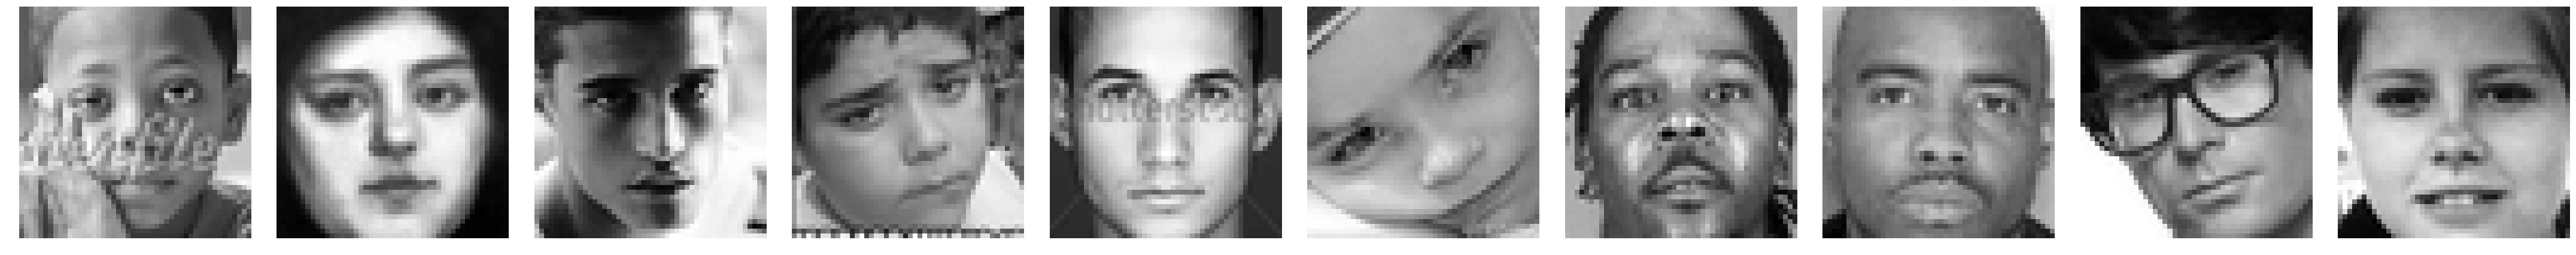

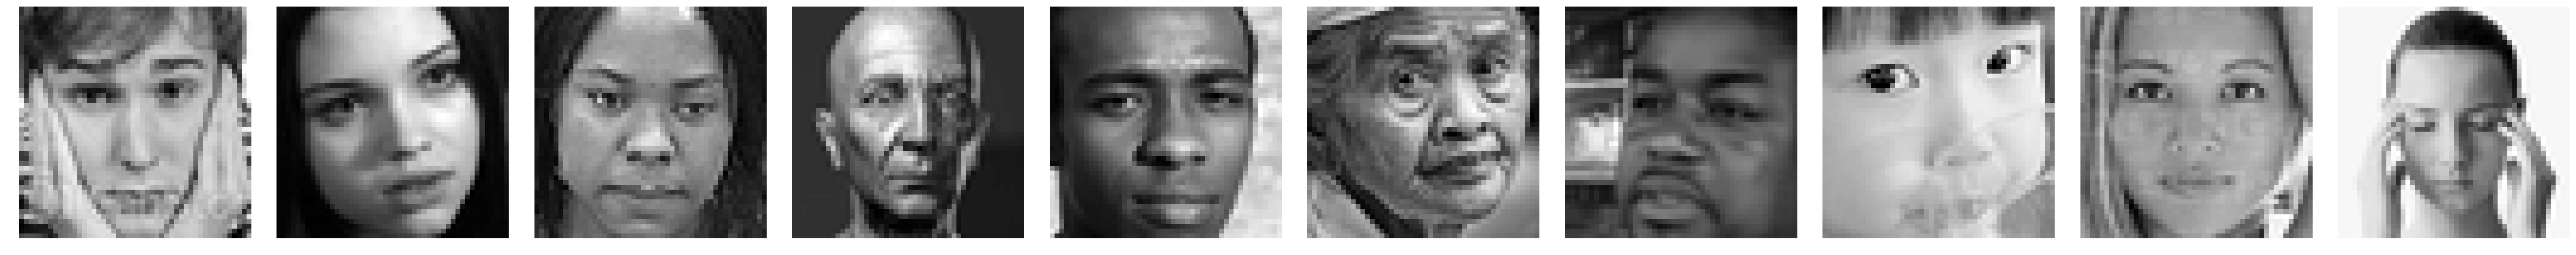

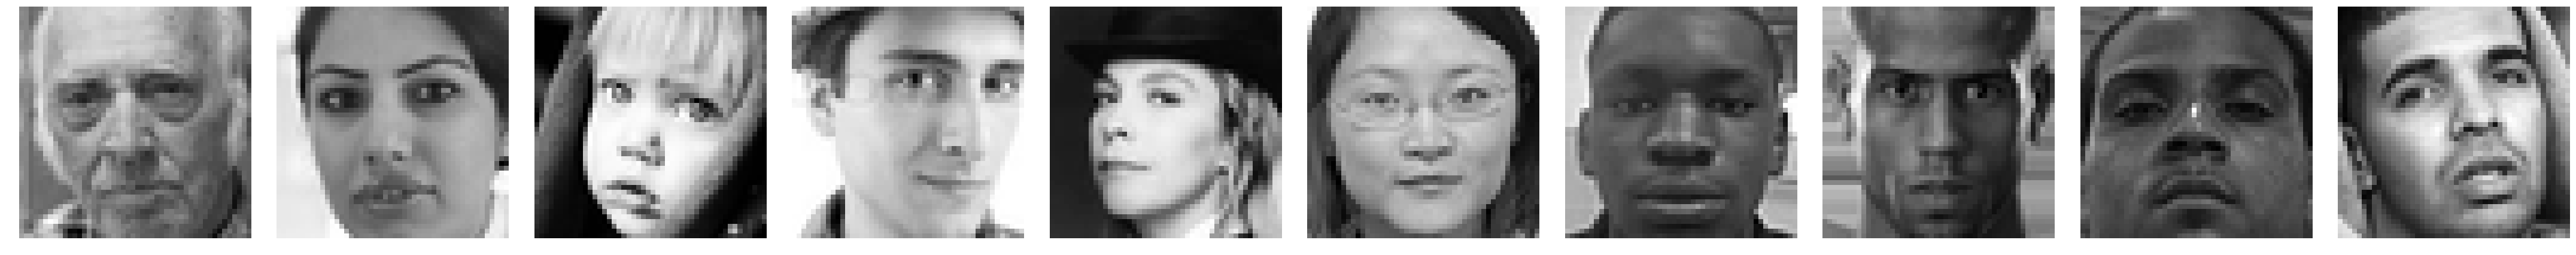

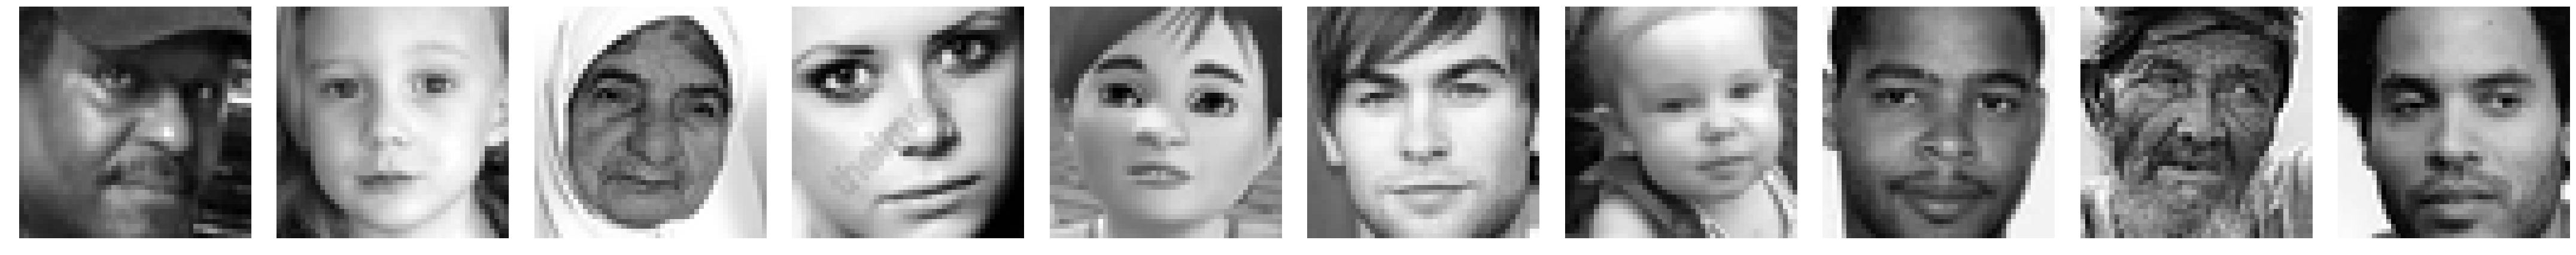

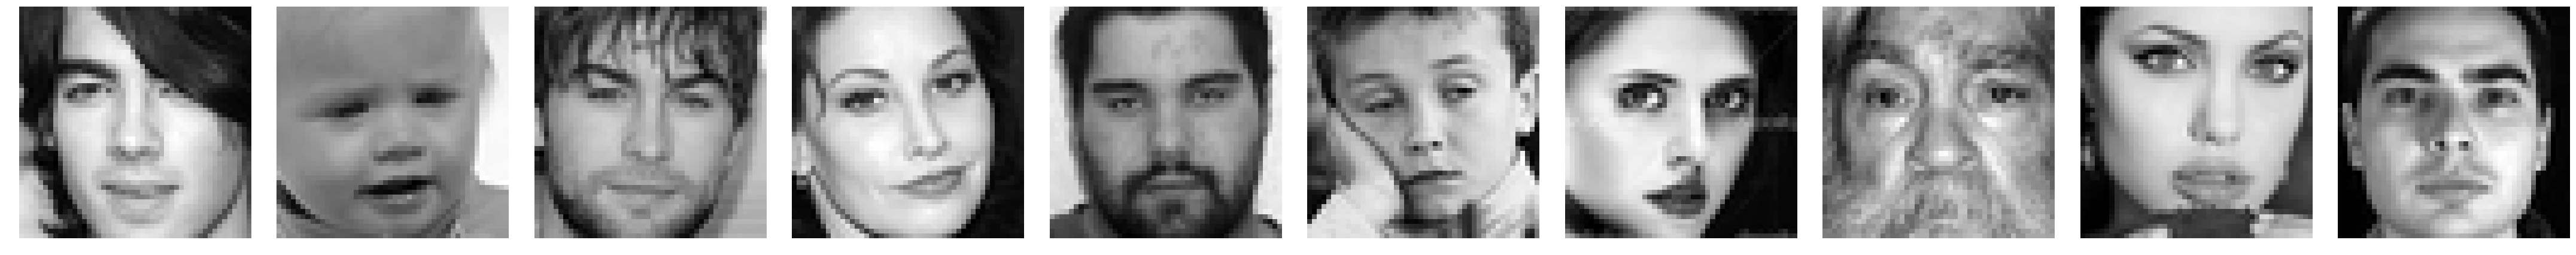

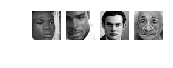

In [23]:
img_width = 48
df = df.sort_values('emotion')
df_group = df.groupby('emotion')
i=1
for emotion_ID, df_by_emotion in df_group:
    print('\n',emotion_dict.get(emotion_ID),'(subset of 100 imgs)------------------')
    for row in range(df_by_emotion.shape[0]):
        img = np.array(df_by_emotion.iloc[row,1].split()).astype(float).reshape((img_width,img_width))
        if i>10:
            plt.tight_layout(rect=(0,0,10,3))
            plt.show()
            i=1
        plt.subplot(1,10,i)
        plt.imshow(img,cmap='gray')
        plt.axis('off')
        i+=1
        
        if row > 100:
            break

__Note__: We can see a few incorrectly labeled images here and there, specifically, there are some pure black images and some images with text. Hopefully the network will learn to catch those.

# Inspect Class Balance

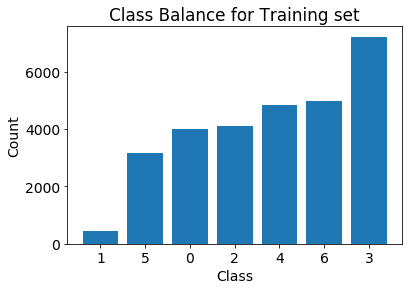

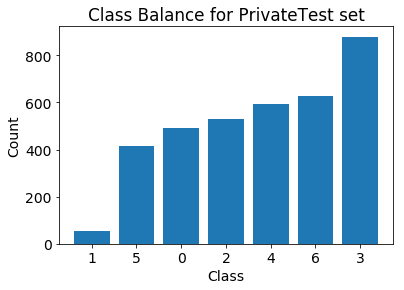

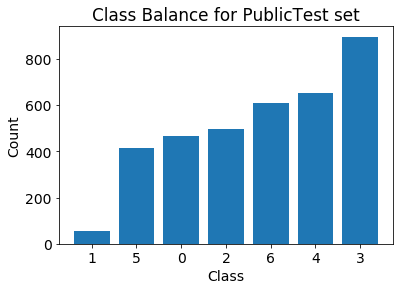

In [29]:
for Usage_ID in df['Usage'].unique():
    plt.title('Class Balance for '+ Usage_ID+' set')
    class_counts = np.array(df[df['Usage']==Usage_ID].groupby('emotion').size().reset_index().sort_values(0))
    plt.bar(x = class_counts[:,0].astype(str),height=class_counts[:,1])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

Looks like similar distribution in each data set, so that's good, since we want the training set distribution to be that same as we will see in the field. However, because the classes are not equally distributed in the training set, our trained model might get really good at classifying class 3 objects and really bad at class 1 objects, but still do pretty well overall. To prevent this from happening, we need to balance the classes in our training set

## Balance the Classes

In [30]:
def balance_classes(df):
    df_group = df.groupby('emotion')
    class_counts = np.array(df_group.size().reset_index().sort_values(0))
    max_counts = class_counts[:,1].max()
    df = pd.DataFrame()
    for class_ID, df_by_class in df_group:
        n_pts_to_generate = max_counts-df_by_class.shape[0]
        while n_pts_to_generate >0:
            slice_length = np.min([n_pts_to_generate, df_by_class.shape[0]])
            df_by_class = pd.concat((df_by_class,df_by_class.iloc[0:slice_length,:]))
            n_pts_to_generate = max_counts-df_by_class.shape[0]
        df = pd.concat((df,df_by_class)).reset_index(drop=True)
    return df

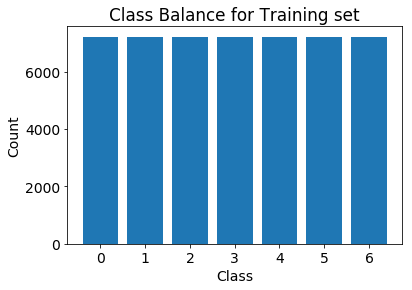

In [32]:
Usage_ID = 'Training'
df_train = balance_classes(df[df['Usage']==Usage_ID])

plt.title('Class Balance for '+ Usage_ID+' set')
class_counts = np.array(df_train.groupby('emotion').size().reset_index().sort_values(0))
plt.bar(x = class_counts[:,0].astype(str),height=class_counts[:,1])
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## Generate Report Folder and Save Balanced Classes

In [33]:
path_report_folder = './report/'
if os.path.isdir(path_report_folder)==False:
    os.mkdir(path_report_folder)

In [34]:
df_train.to_csv(path_report_folder+'df_train_classes_balanced.csv',index=False)

# Train, Validation, Test Split & One Hot Encoding

In [104]:
df_train = pd.read_csv(path_report_folder +'df_train_classes_balanced.csv')
df_test = df[df['Usage']=='PrivateTest'].reset_index(drop=True)
df_valid = df[df['Usage']=='PublicTest'].reset_index(drop=True)

n_classes = len(df_train['emotion'].unique())
print('n_classes:', n_classes)

n_classes: 7


In [36]:
import sklearn.preprocessing
def build_input_tensor(df, img_width):
    np_labels = np.array(df['emotion']).reshape(-1,1)
    onehot_encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)
    np_labels_onehot = onehot_encoder.fit_transform(np_labels)
    
    np_imgs = np.zeros((df.shape[0],img_width,img_width,1))
    for row in range(df.shape[0]):
        np_imgs[row,:,:,0] = np.array(df.iloc[row,1].split()).astype(float).reshape((img_width,img_width))
        
    return np_labels, np_labels_onehot, np_imgs

In [37]:
_, np_labels_train, np_imgs_train = build_input_tensor(df_train, img_width)
_, np_labels_valid, np_imgs_valid = build_input_tensor(df_valid, img_width)
_, np_labels_test, np_imgs_test = build_input_tensor(df_test, img_width)

# Build Model

In [38]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

## Build generators for Img augmentation on training set

In [39]:
train_gen = keras.preprocessing.image.ImageDataGenerator(
                    zca_whitening=True,
                    zca_epsilon=1e-06,
                    rotation_range=40,
                    fill_mode='nearest',
                    horizontal_flip=True,
                    vertical_flip=True,
                    zoom_range=0.2,
                    rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

/Users/johnleonard/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image.py:836: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


### Inspect subset of augmented images

/Users/johnleonard/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/johnleonard/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image.py:1150: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


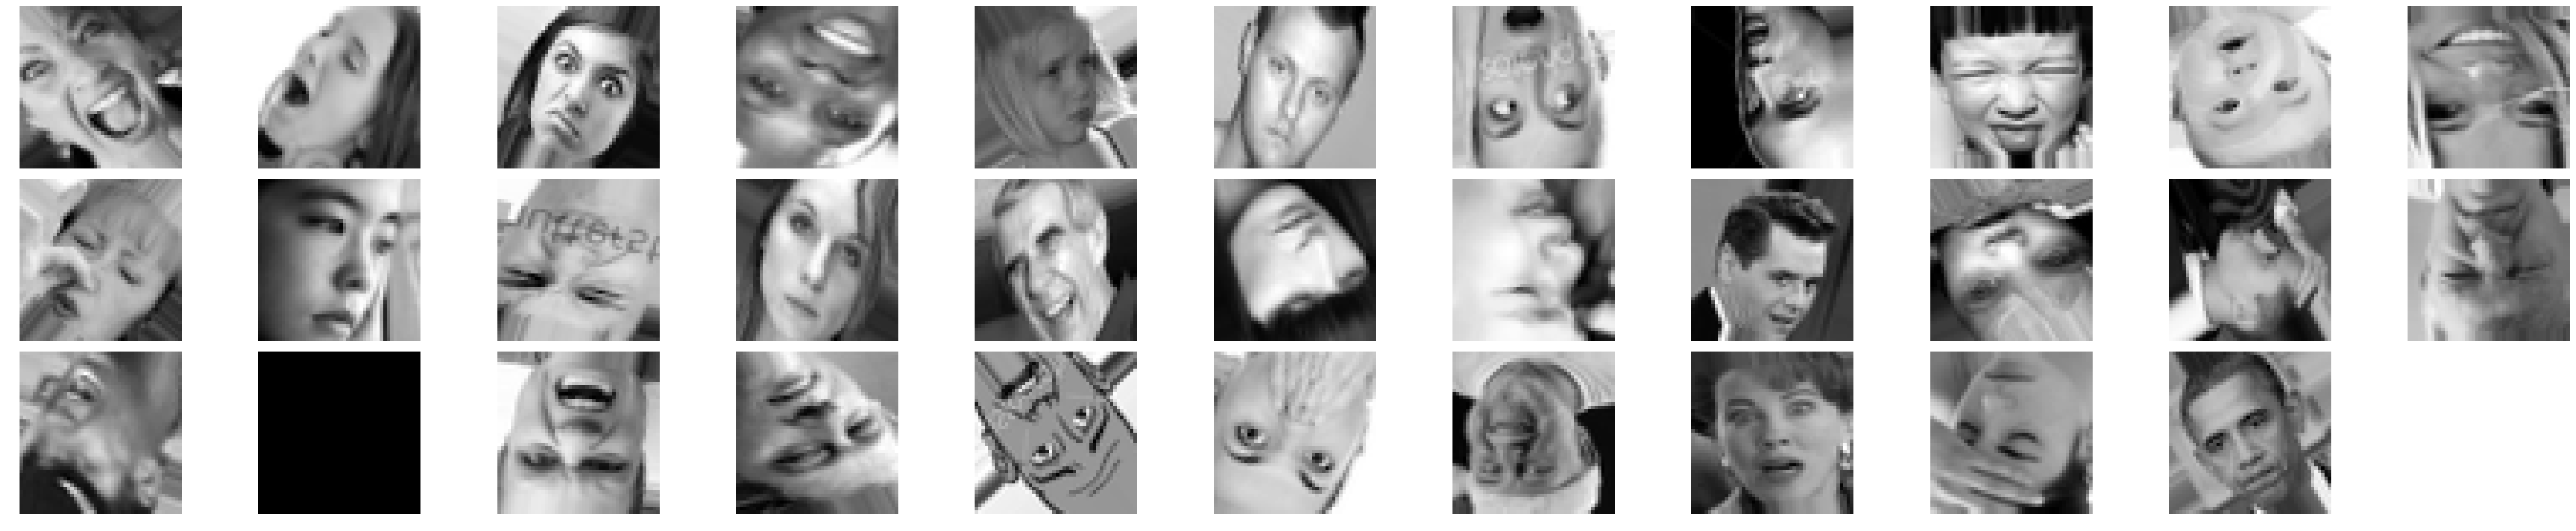

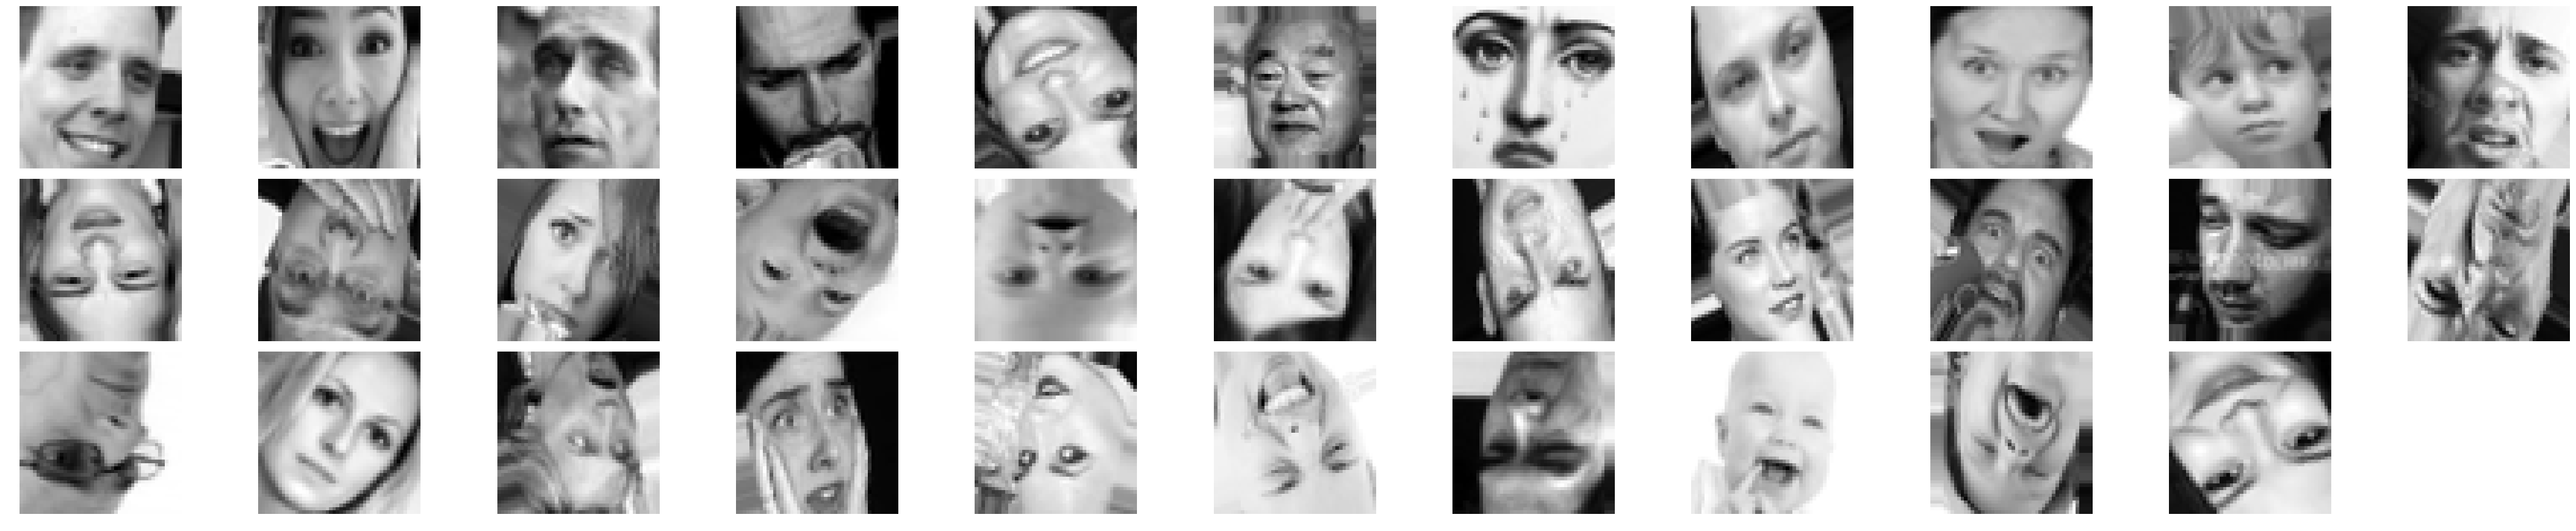

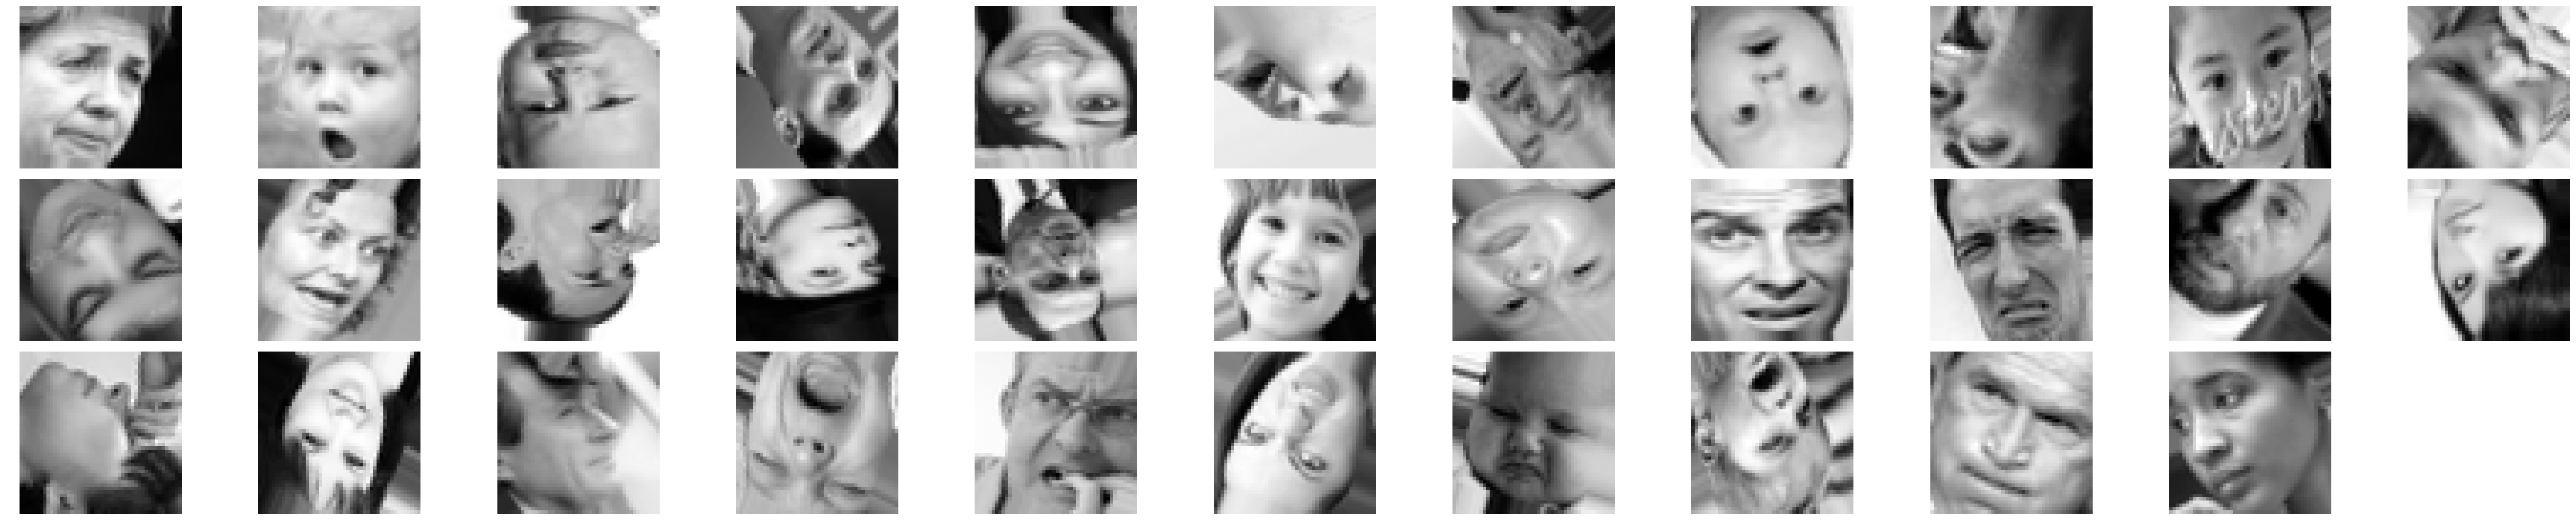

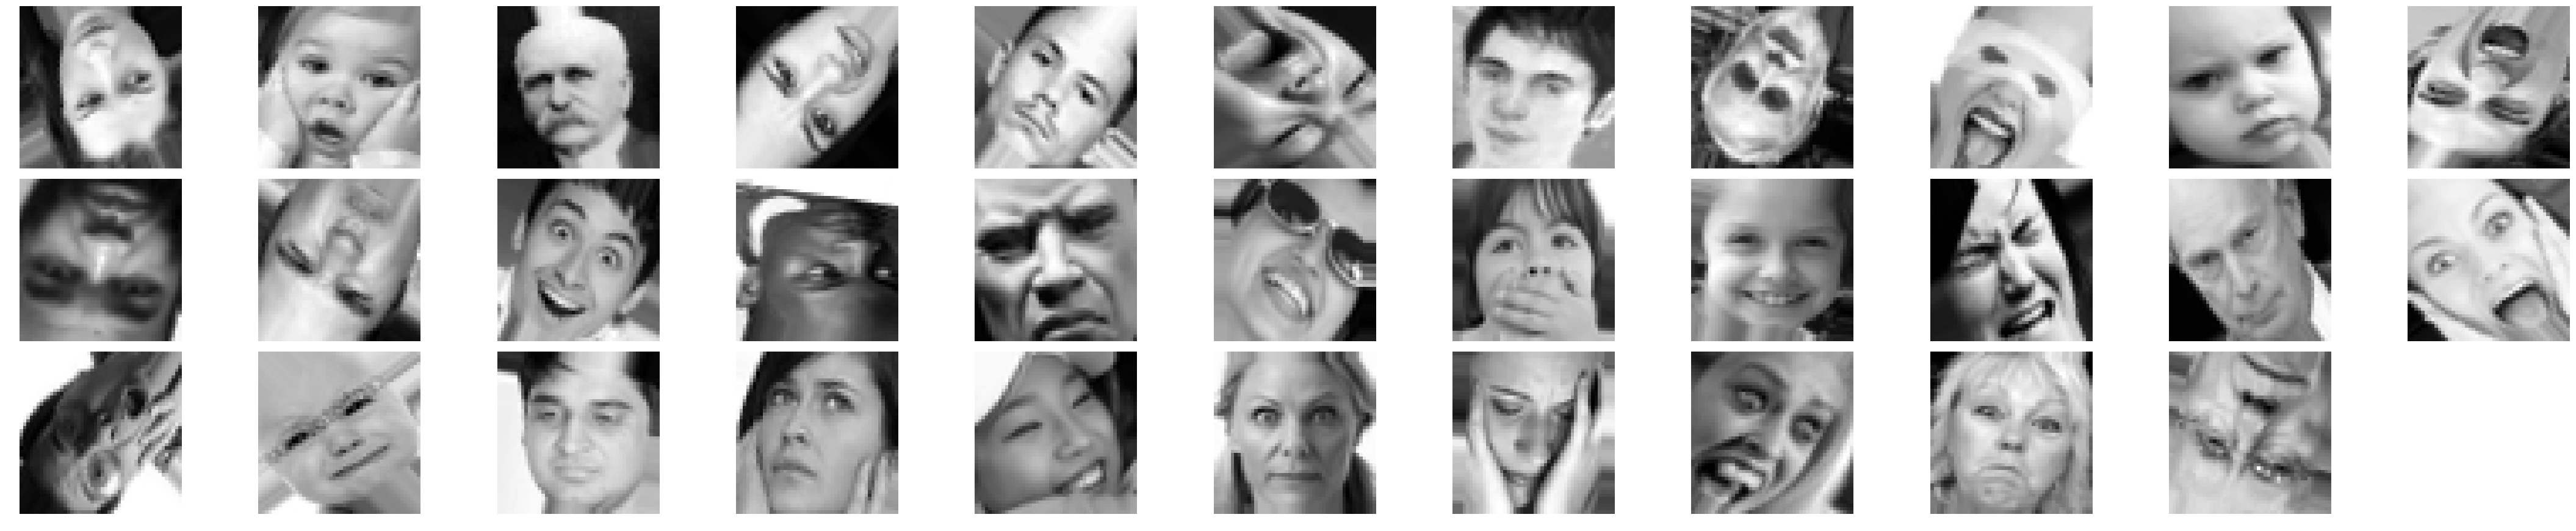

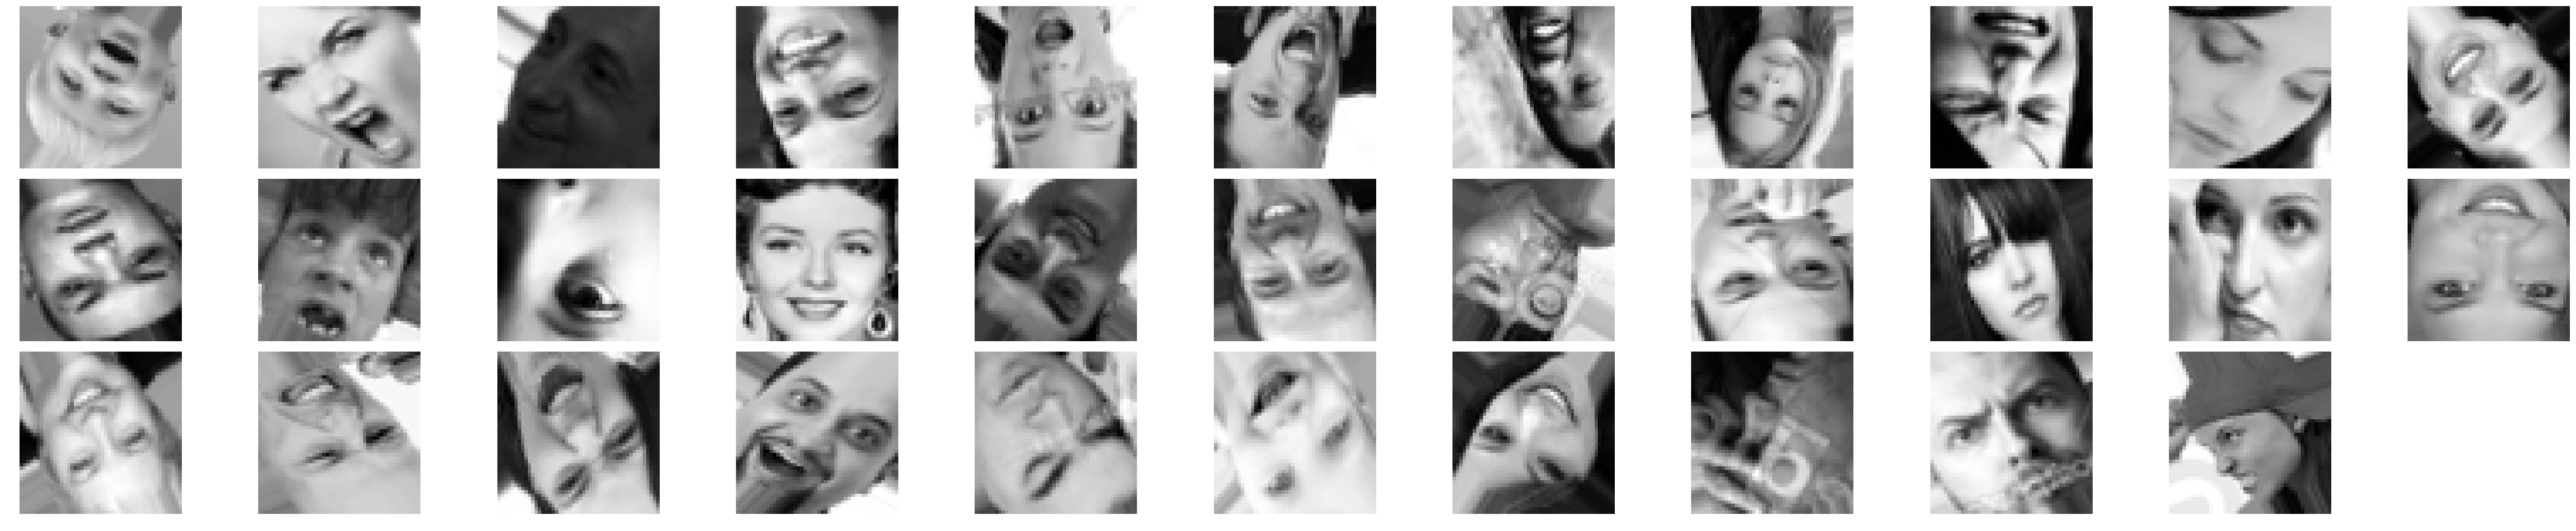

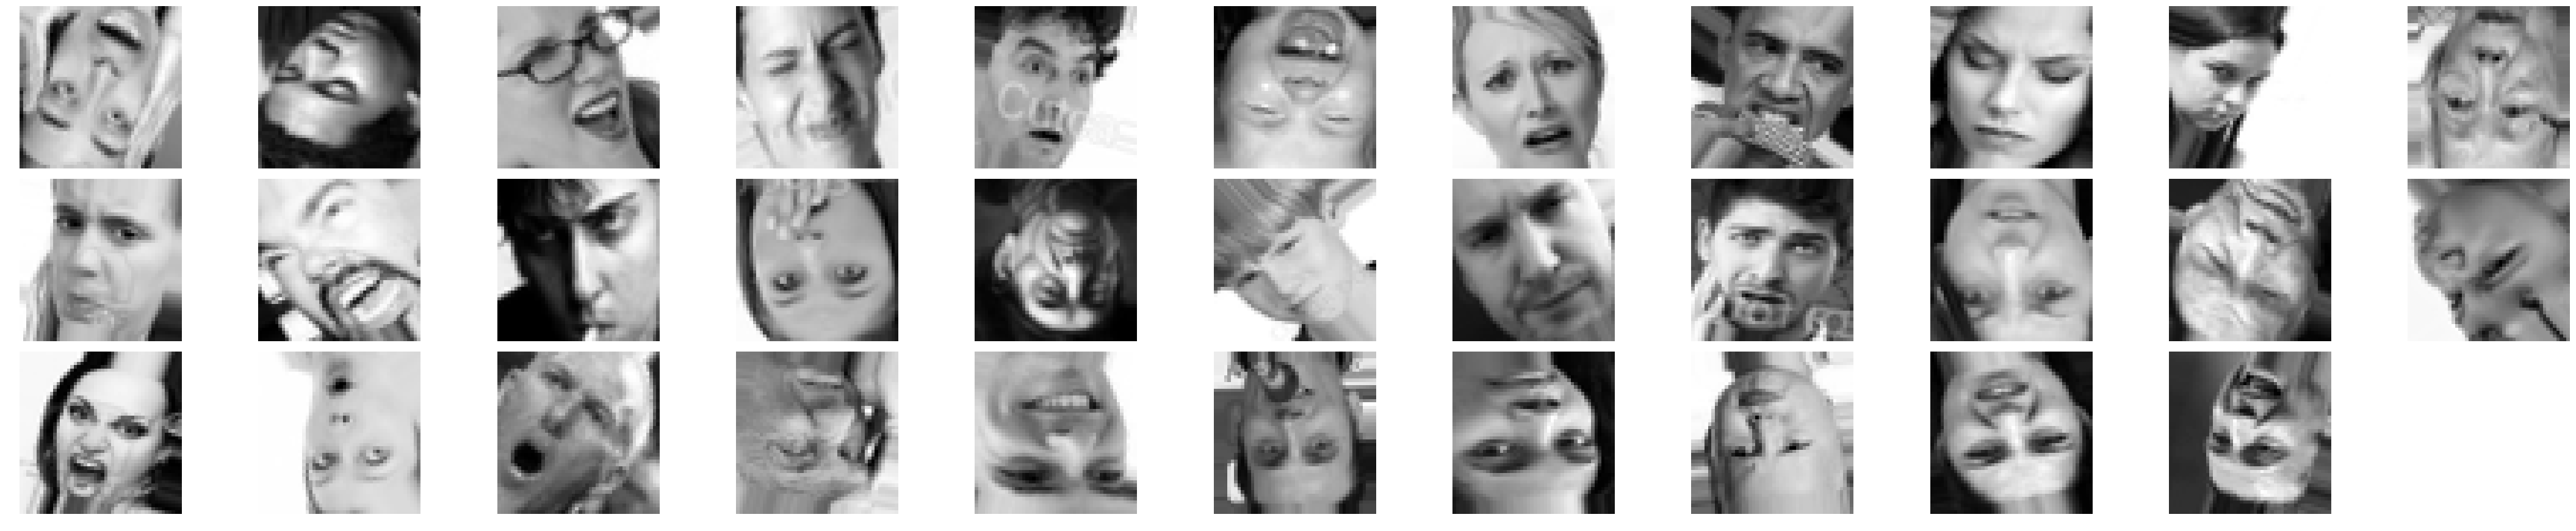

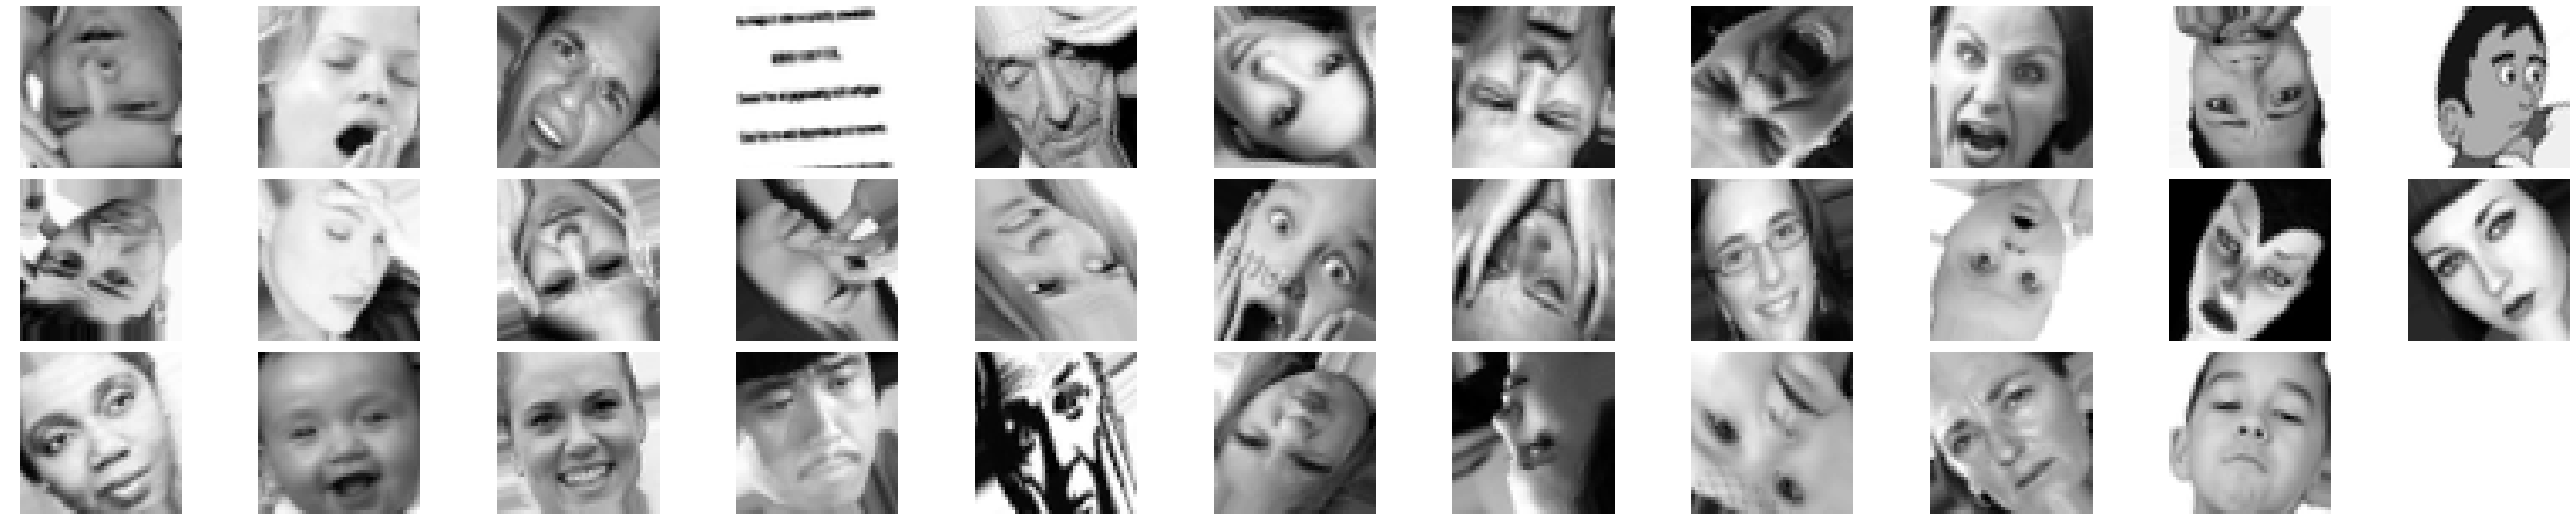

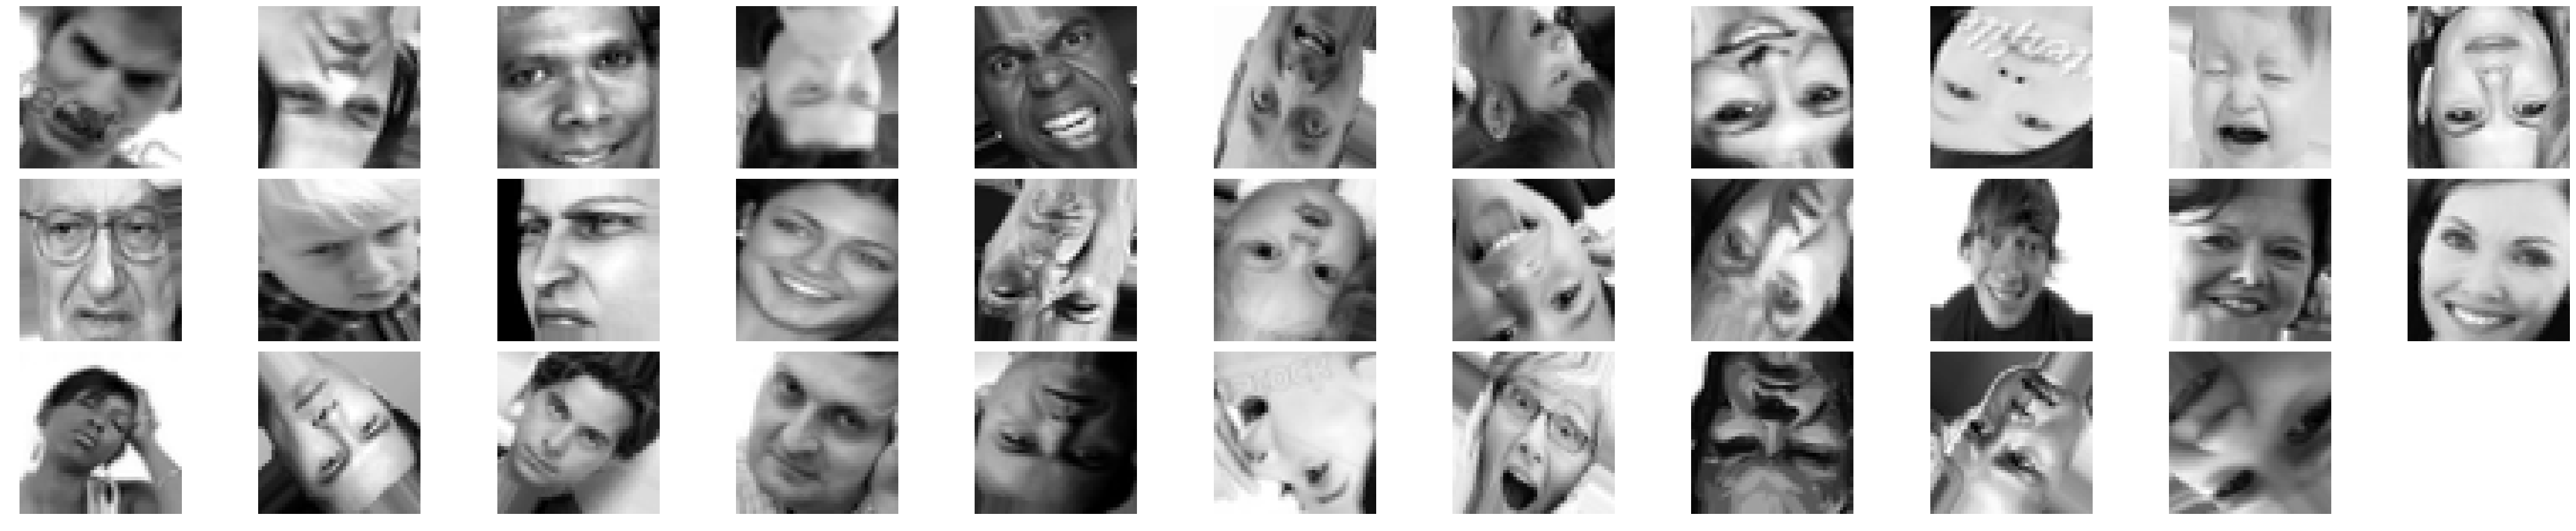

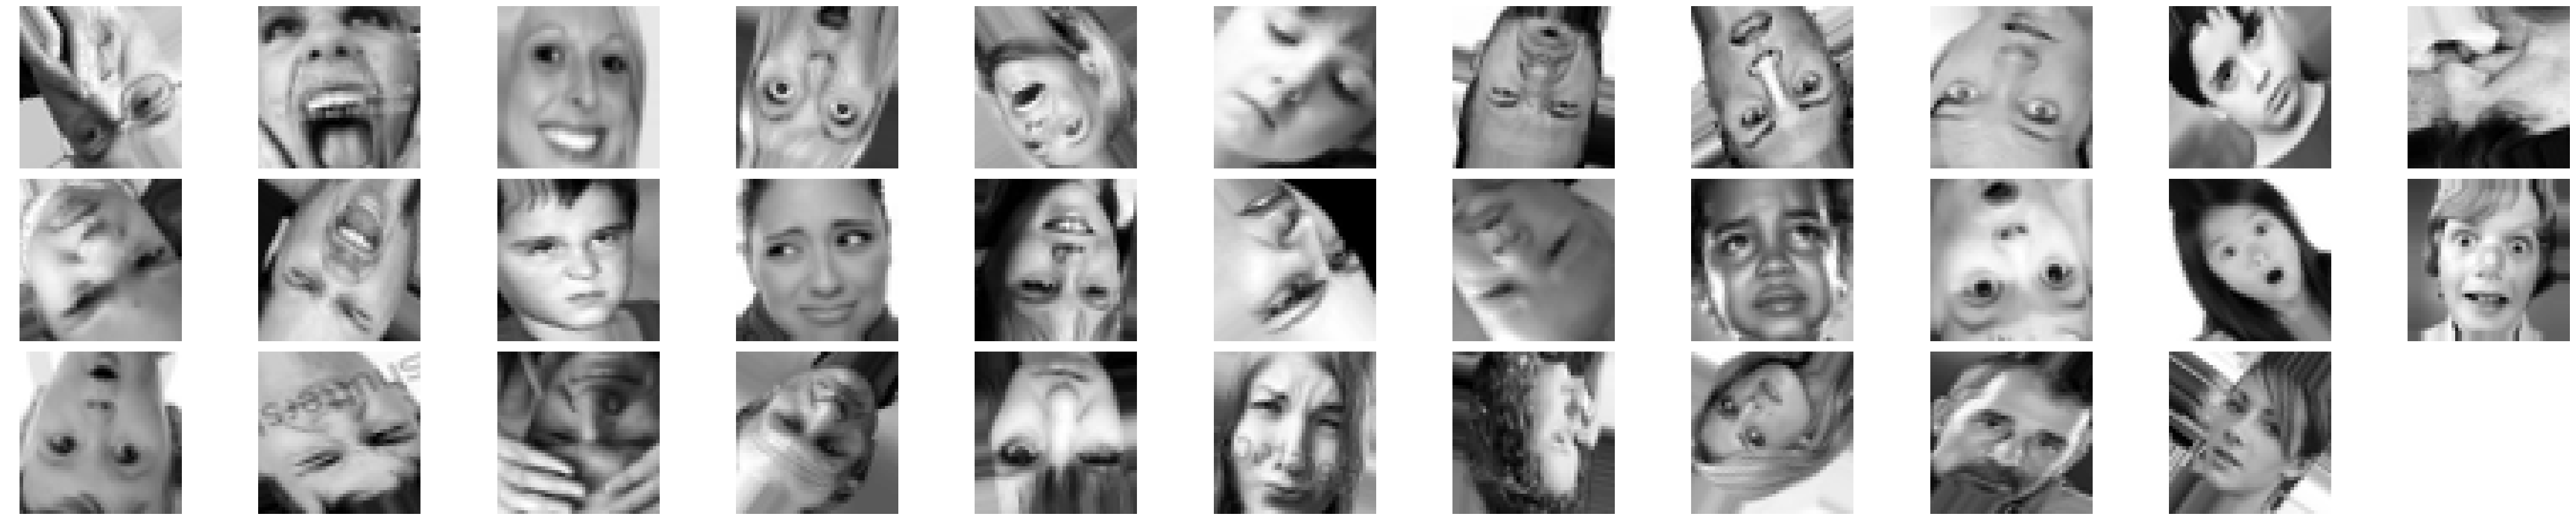

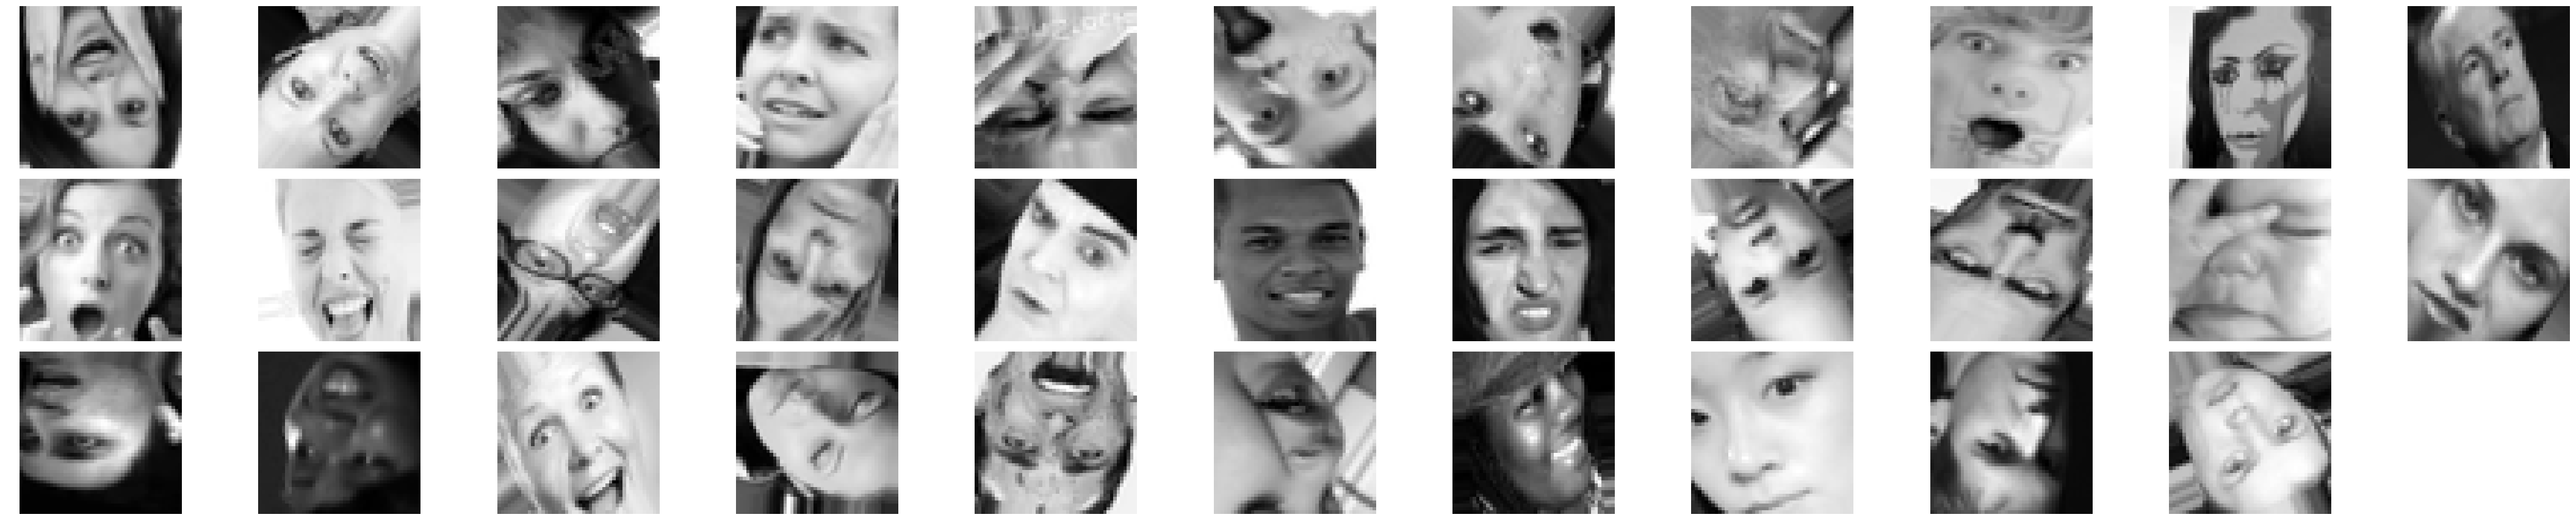

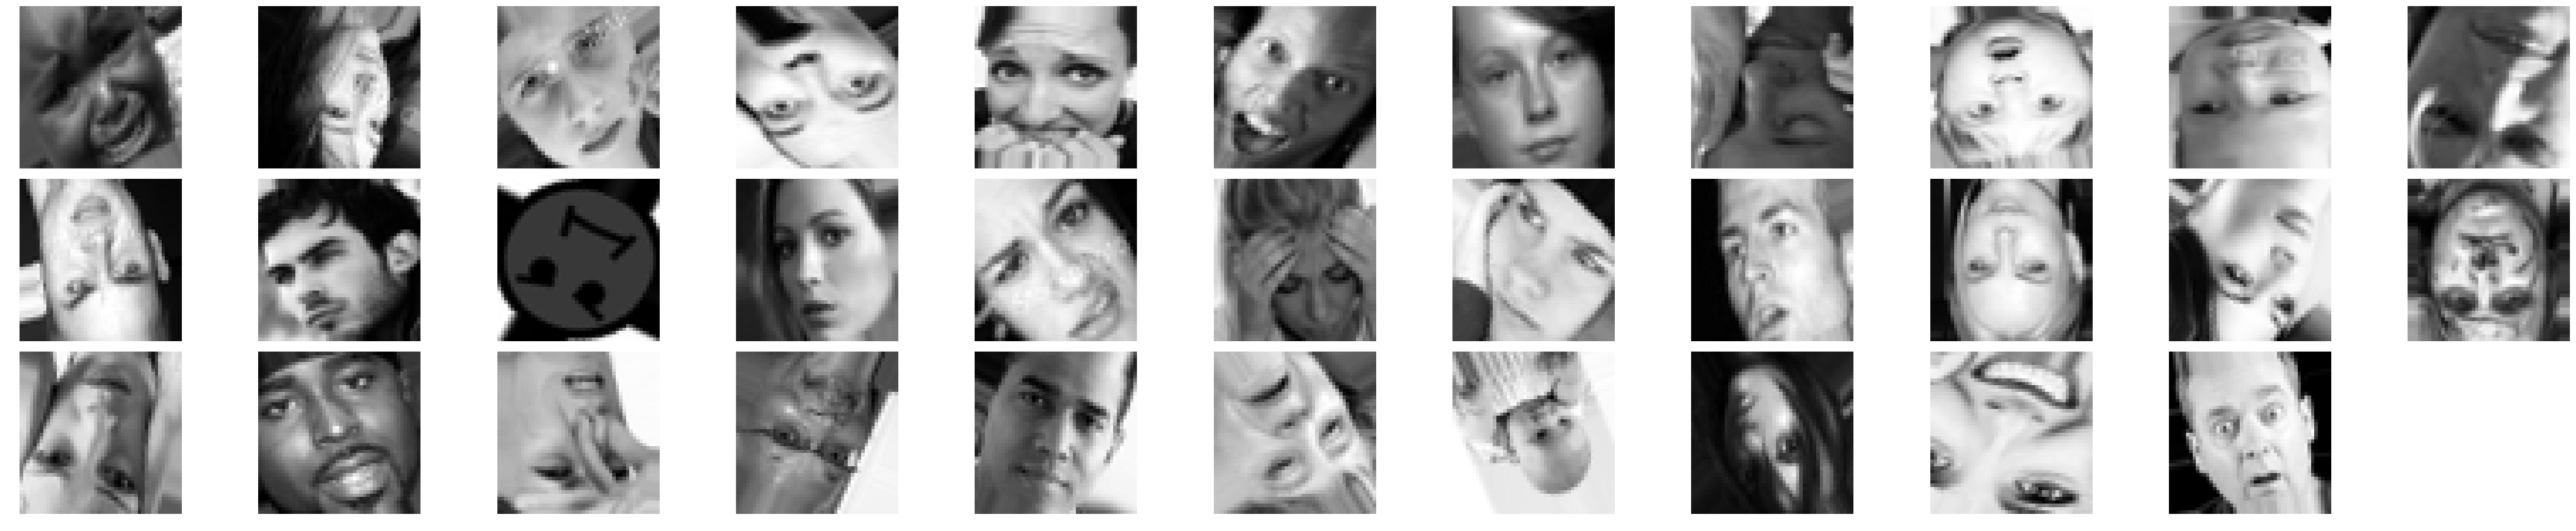

In [40]:
generator_batch_size =32
test = train_gen.flow(x = np_imgs_train, 
                          y = np_labels_train,
                          batch_size=generator_batch_size)

j=0
for img_batch, labels_of_batch in test:
    i=1
    for img in img_batch:
        plt.subplot(3,int(generator_batch_size/3)+1,i)
        plt.imshow(img[:,:,0],cmap='gray')
        plt.axis('off')
        i+=1
    plt.tight_layout(rect=(0,0,10,3))
    plt.show()
    j+=1
    if j>10:
        break

## Define Neural Net

### VGG 16 Baseline

In [134]:
def VGG_model(img_dims, n_classes, drop_rate, debug=False):
    
    keras.backend.clear_session()
    
    layers_dict = {}
    
    stack_idx = 0
    layers_dict[str(stack_idx)+'_input'] = layers.Input(shape = img_dims)
    if debug: print(layers_dict[list(layers_dict.keys())[-1]])
    
    def conv_layer_stack(layer_in, filters, drop_rate, debug=False):
        L1 = layers.Conv2D(filters, kernel_size=(3,3), padding='same', activation='relu')(layer_in)
        L2 = layers.Conv2D(filters, kernel_size=(3,3), padding='same', activation='relu')(L1)
        MaxP = layers.MaxPool2D(pool_size=(2, 2), strides=(2,2))(L2)
        Dropout = layers.Dropout(rate = drop_rate)(MaxP)
        if debug: print('',L1,'\n',L2,'\n',MaxP,'\n',Dropout)
        return Dropout
    
    stack_idx+=1
    filter0 = 64
    while filter0<=512:
        if debug: print('stack_idx:',stack_idx)
        layers_dict[str(stack_idx)+'_conv_stack'] = conv_layer_stack((layers_dict[list(layers_dict.keys())[-1]]),
                                                                                filter0,
                                                                                drop_rate,
                                                                                debug)
        filter0 = filter0*2
        stack_idx+=1
        
    # one more 512 filter conv stack
    filter0 = filter0//2
    if debug:  print('stack_idx:',stack_idx)
    layers_dict[str(stack_idx)+'_conv_stack'] = conv_layer_stack((layers_dict[list(layers_dict.keys())[-1]]),
                                                                            filter0,
                                                                            drop_rate,
                                                                            debug)
    # flatten
    stack_idx+=1
    layers_dict[str(stack_idx)+'_flat'] = layers.Flatten()(layers_dict[list(layers_dict.keys())[-1]])
    if debug: print(layers_dict[list(layers_dict.keys())[-1]])
    
    # Dense
    HLs = filter0*8
    for i in range(2):
        stack_idx+=1
        layers_dict[str(stack_idx)+'_Dense'] = layers.Dense(HLs, activation='relu')(layers_dict[list(layers_dict.keys())[-1]])
        if debug: print(layers_dict[list(layers_dict.keys())[-1]])
    
    # Dropout
    stack_idx+=1
    layers_dict[str(stack_idx)+'_Drop'] = layers.Dropout(rate = drop_rate)(layers_dict[list(layers_dict.keys())[-1]])
    if debug: print(layers_dict[list(layers_dict.keys())[-1]]) 
        
    # Dense Compression
    HLs = HLs//4
    while HLs > n_classes:
        stack_idx+=1
        layers_dict[str(stack_idx)+'_Dense'] = layers.Dense(HLs, activation='relu')(layers_dict[list(layers_dict.keys())[-1]])
        if debug: print(layers_dict[list(layers_dict.keys())[-1]])
        HLs = HLs//4
        
    HLs = n_classes
    stack_idx+=1
    layers_dict[str(stack_idx)+'_Dense'] = layers.Dense(HLs, activation='relu')(layers_dict[list(layers_dict.keys())[-1]])
    if debug: print(layers_dict[list(layers_dict.keys())[-1]])
    
    stack_idx+=1
    activation = 'softmax'
    layers_dict[str(stack_idx)+'_'+activation] = layers.Dense(HLs, activation=activation)(layers_dict[list(layers_dict.keys())[-1]])
    if debug: print(layers_dict[list(layers_dict.keys())[-1]])
    
    model = keras.Model(inputs = layers_dict[list(layers_dict.keys())[0]],
                        outputs = layers_dict[list(layers_dict.keys())[-1]])
    
    display(model.summary())
    
    return model

In [137]:
model = VGG_model(img_dims=(img_width,img_width,1), 
                  n_classes = n_classes, 
                  drop_rate = 0, 
                  debug=False)

model.compile(optimizer='Adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       147584    
__________

None

In [140]:
model.fit(x=np_imgs_train,
            y=np_labels_train,
            batch_size=512,
            epochs=1000,
            verbose=1,
            callbacks=None,
            validation_data=(np_imgs_valid, np_labels_valid),
            shuffle=True)

Train on 50505 samples, validate on 3589 samples
Epoch 1/1000
 2048/50505 [>.............................] - ETA: 31:06 - loss: 1.9459 - acc: 0.1460

KeyboardInterrupt: 